# Coursework 1 - Supervised learning

**Replace CID in the file name with your CID**

# Outline


- [Task 1](#task-1): Regression <a name="index-task-1"></a>
  - [(1.1)](#task-11) Random Forest <a name="index-task-11"></a>
    - [(1.1.1)](#task-111) <a name="index-task-111"></a>
    - [(1.1.2)](#task-112) <a name="index-task-112"></a>
    - [(1.1.3)](#task-113) <a name="index-task-113"></a>
  - [(1.2)](#task-12) Multi-layer Perceptron <a name="index-task-12"></a>
    - [(1.2.1)](#task-121) <a name="index-task-121"></a>
    - [(1.2.2)](#task-122) <a name="index-task-122"></a>
    - [(1.2.3)](#task-123) <a name="index-task-123"></a>
- [Task 2](#task-2): Classification <a name="index-task-2"></a>
  - [(2.1)](#task-21) k-Nearest Neighbours <a name="index-task-21"></a>
    - [(2.1.1)](#task-211)  <a name="index-task-211"></a>
    - [(2.1.2)](#task-212) <a name="index-task-212"></a>
    - [(2.1.3)](#task-213) <a name="index-task-213"></a>
  - [(2.2)](#task-22) Logistic regression vs kernel logistic regression <a name="index-task-22"></a>
    - [(2.2.1)](#task-221) <a name="index-task-221"></a>
    - [(2.2.2)](#task-222) <a name="index-task-222"></a>
    - [(2.2.3)](#task-223) <a name="index-task-223"></a>



---



In [1]:
# import packages
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

<a name="task-1"></a>

# (1) Task 1: Regression [(index)](#index-task-1)

<a name="task-11"></a>

## (1.1) Random Forest [(index)](#index-task-11)

<a name="task-111"></a>

### (1.1.1) [(index)](#index-task-111)

In [2]:
# import data and split into target variable and 12 features

# training set data
capacitance_samples = pd.read_csv('nanoelectrodes_capacitance_samples.csv')
X_train_df = capacitance_samples[capacitance_samples.columns[np.arange(13)!=6]]
y_train_df = capacitance_samples[capacitance_samples.columns[6]]

# store the names of the features in a list
feature_names = X_train_df.columns.tolist()

# test set data
capacitance_test = pd.read_csv('nanoelectrodes_capacitance_test.csv')
X_test_df = capacitance_test[capacitance_test.columns[np.arange(13)!=6]]
y_test_df = capacitance_test[capacitance_test.columns[6]]

# observe features
print(f'number of predictors = {X_test_df.shape[1]}')
X_test_df.head()

number of predictors = 12


,Surface_Area ($m^2/g$),Defect_Ratio,Doped_Nitrogen_Percentage,Doped_Oxygen_Percentage,Doped_Sulfur_Percentage,Current_Density ($A/g$),Electrolyte_Concentration $[M]$,H9_Factor ($mL/g$),T5_Factor ($mL/g$),Doped_Zinc_Percentage,Doped_Flourine_Percentage,Doped_Carbon_Percentage
0,444.50,0.84,2.51,4.76,3.71,10.0,6.0,49.609432,51.225638,46.902466,25.685810,45.407250
1,196.80,1.02,2.50,19.42,0.20,0.5,6.0,22.008342,5.978067,77.697696,43.395016,56.839706
2,1122.50,0.85,4.20,5.70,1.30,1.0,6.0,115.085236,7.235982,54.830009,41.491648,72.580806
3,39.05,1.02,4.16,9.39,2.21,1.0,6.0,4.309532,6.812445,39.595893,33.487503,58.428443
4,370.40,1.32,4.80,7.76,2.01,1.0,1.0,38.785107,7.970446,47.852171,45.612992,84.529863


We standardise the dataset using the convention discussed in the lecture. This makes it easier to compare the performance of different models.

In [3]:
def standardise(X, X_train_=None):
    """
    Standardise features.
    Parameters:
        X (np.array): Feature matrix.
        X_train_ (np.array): An optional feature matrix to compute the statistics
            from before applying it to X. If None, just use X to compute the statistics.
    Returns:
        X_std (np.array): Standardised feature matrix
    """
    if X_train_ is None:
        X_train_ = X

    mu = np.mean(X_train_, axis=0, keepdims=True) 
    sigma = np.std(X_train_, axis=0, keepdims=True) 
    X_std = (X - mu) / sigma
    return X_std

In [4]:
# transform training and test data into standardised arrays
X_train = standardise(np.array(X_train_df))
X_test = standardise(np.array(X_test_df), np.array(X_train_df))

In [5]:
def mse(y):
    # Return MSE
    return np.mean((y-np.mean(y))**2)

In [6]:
# we assume all examples have the same weight.
training_weights = np.ones_like(y_train_df) / len(y_train_df)

# dictionary indicates whether the column index maps to a categorical or numerical feature
columns_dict = {index: False for index in range(X_train_df.shape[1])}

In [7]:
def split_samples(X, y, column, value, categorical):
    """
    Return the split of data whose column-th feature:
      1. equals value, in case `column` is categorical, or
      2. less than value, in case `column` is not categorical (i.e. numerical)

    Arguments:
        X: training features, of shape (N, p).
        y: vector of training labels, of shape (N,).
        sample_weights: weights for each samples, of shape (N,).
        column: the column of the feature for splitting.
        value: splitting threshold  the samples
        categorical: boolean value indicating whether column is a categorical variable or numerical.
    Returns:
        tuple(np.array, np.array, np.array): tuple of the left split data (X_l, y_l).
        tuple(np.array, np.array, np.array): tuple of the right split data (X_l, y_l)
    """
    if categorical:
        left_mask =(X[:, column] == value)
    else:
        left_mask = (X[:, column] < value)

    # Using the binary masks `left_mask`, we split X, y, and sample_weights.
    X_l, y_l = X[left_mask, :], y[left_mask]
    X_r, y_r = X[~left_mask, :], y[~left_mask] 

    return (X_l, y_l), (X_r, y_r)

In [8]:
def mse_split_value(X, y, column, categorical):
    """
    Calculate the MSE based on `column` with the split that minimises the MSE.
    Arguments:
        X: training features, of shape (N, p).
        y: vector of training labels, of shape (N,).
        sample_weights: weights for each samples, of shape (N,).
        column: the column of the feature for calculating. 0 <= column < D
        categorical: boolean value indicating whether column is a categorical variable or numerical.
    Returns:
        (float, float): the resulted MSE and the corresponding value used in splitting.
    """

    unique_vals = np.unique(X[:, column])

    assert len(unique_vals) > 1, f"There must be more than one distinct feature value. Given: {unique_vals}."

    mse_val, threshold = np.inf, None

    # split the values of i-th feature and calculate the cost
    for value in unique_vals:
        (X_l, y_l), (X_r, y_r) = split_samples(X, y, column, value, categorical)

        # if one of the two sides is empty, skip this split.
        if len(y_l) == 0 or len(y_r) == 0:
            continue

        new_cost = len(y_l)/len(y) * mse(y_l) + len(y_r)/len(y) * mse(y_r)
        if new_cost < mse_val:
              mse_val, threshold = new_cost, value

    return mse_val, threshold

In [9]:
def mse_split(X, y, columns_dict):
    """
    Choose the best feature to split according to criterion.
    Args:
        X: training features, of shape (N, p).
        y: vector of training labels, of shape (N,).
        sample_weights: weights for each samples, of shape (N,).
        columns_dict: a dictionary mapping column indices to whether the column is categorical or numerical variable.
    Returns:
        (int, float): the best feature index and value used in splitting.
        If the feature index is None, then no valid split for the current Node.
    """
    # Initialise `split_column` to None, so if None returned this means there is no valid split at the current node.
    min_mse = np.inf
    split_column = None
    split_val = np.nan

    for column, categorical in columns_dict.items():
        # skip column if samples are not seperable by that column.
        if len(np.unique(X[:, column])) < 2:
            continue
        mse, current_split_val = mse_split_value(X, y, column, categorical)


        if mse < min_mse: 
            # Keep track with:

            # 1. the current minimum MSE value,
            min_mse = mse

            # 2. corresponding column,
            split_column = column 

            # 3. corresponding split threshold.
            split_val = current_split_val 

    return split_column, split_val

In [10]:
def mean_vote(y):
    """
    Return the mean of the labels.
    Args:
        y: vector of training labels, of shape (N,).
    Returns:
        (int): the mean of the labels
    """
    return np.mean(y)

In [11]:
def build_tree(X, y, columns_dict, feature_names, depth,  max_depth=10, min_samples_leaf=10):
    """Build the decision tree according to the data.
    Args:
        X: (np.array) training features, of shape (N, p).
        y: (np.array) vector of training labels, of shape (N,).
        columns_dict: a dictionary mapping column indices to whether the column is categorical or numerical variable.
        feature_names (list): record the name of features in X in the original dataset.
        depth (int): current depth for this node.
        max_depth (int): maximum depth allowed for the tree.
        min_samples_leaf (int): minimum number of samples required to be at a leaf node.
    Returns:
        (dict): a dict denoting the decision tree (binary-tree). Each node has seven attributes:
          1. 'feature_name': The column name of the split.
          2. 'feature_index': The column index of the split.
          3. 'value': The value used for the split.
          4. 'categorical': indicator for categorical/numerical variables.
          5. 'mean_label': For leaf nodes, this stores the mean label. Otherwise, it is None.
          6. 'left': The left sub-tree with the same structure.
          7. 'right' The right sub-tree with the same structure.
    """
    # include a clause for the cases where (i) no feature, (ii) all labels are the same, (iii) depth exceed, or (iv) X is too small
    if len(np.unique(y))==1 or depth>=max_depth or len(X)<=min_samples_leaf:
        return {'mean_label': mean_vote(y)}

    split_index, split_val = mse_split(X, y, columns_dict) 

    # If no valid split at this node, use mean vote.
    if split_index is None:
        return {'mean_label': mean_vote(y)}

    categorical = columns_dict[split_index]

    # Split samples (X, y) given column, split-value, and categorical flag.
    (X_l, y_l), (X_r, y_r) = split_samples(X, y, split_index, split_val, categorical)
    return {
        'feature_name': feature_names[split_index],
        'feature_index': split_index,
        'value': split_val,
        'categorical': categorical,
        'mean_label': None,
        'left': build_tree(X_l, y_l, columns_dict, feature_names, depth + 1, max_depth, min_samples_leaf),
        'right': build_tree(X_r, y_r, columns_dict, feature_names, depth + 1, max_depth, min_samples_leaf)
    }

In [12]:
def train(X, y, columns_dict=None, feature_names=feature_names):
    """
    Build the decision tree according to the training data.
    Args:
        X: (pd.Dataframe) training features, of shape (N, p). Each X[i] is a training sample.
        y: (pd.Series) vector of training labels, of shape (N,). y[i] is the label for X[i], and each y[i] is
        an integer in the range 0 <= y[i] <= C. Here C = 1.
        columns_dict: a dictionary mapping column indices to whether the column is categorical or numerical variable.
        feature_names (list): List of feature names in the original dataset. If None, default feature names will be used.
    Returns:
        (dict): A decision tree model represented as a dictionary. Each node has the following attributes:
            - 'feature_name': The column name of the split.
            - 'feature_index': The column index of the split.
            - 'value': The value used for the split.
            - 'categorical': Indicator for categorical/numerical variables.
            - 'mean_label': For leaf nodes, this stores the mean label. Otherwise, it is None.
            - 'left': The left sub-tree with the same structure.
            - 'right': The right sub-tree with the same structure.
    """
    y = y.to_numpy()
    return build_tree(X, y, columns_dict, feature_names, depth=1)

In [13]:
# fit the decision tree with training data
tree = train(X_train, y_train_df, columns_dict)

In [14]:
tree

{'feature_name': 'Current_Density ($A/g$)',
 'feature_index': 5,
 'value': -0.4045240763812216,
 'categorical': False,
 'mean_label': None,
 'left': {'feature_name': 'Doped_Oxygen_Percentage',
  'feature_index': 3,
  'value': 0.5033402558169106,
  'categorical': False,
  'mean_label': None,
  'left': {'feature_name': 'Doped_Nitrogen_Percentage',
   'feature_index': 2,
   'value': -1.1368156865069619,
   'categorical': False,
   'mean_label': None,
   'left': {'mean_label': 356.2857142857143},
   'right': {'feature_name': 'Doped_Sulfur_Percentage',
    'feature_index': 4,
    'value': -0.02797466255849474,
    'categorical': False,
    'mean_label': None,
    'left': {'feature_name': 'Defect_Ratio',
     'feature_index': 1,
     'value': 0.2921771344590554,
     'categorical': False,
     'mean_label': None,
     'left': {'feature_name': 'Surface_Area ($m^2/g$)',
      'feature_index': 0,
      'value': -0.8127917997059619,
      'categorical': False,
      'mean_label': None,
      'le

In [15]:
def classify(tree, x):
    """
    Classify a single sample with the fitted decision tree.
    Args:
        x: ((pd.Dataframe) a single sample features, of shape (D,).
    Returns:
        (int): predicted testing sample label.
    """
    if tree['mean_label'] is not None:
        return tree['mean_label']

    else:
        if x[tree['feature_index']] < tree['value']:
            # go to left branch
            return classify(tree['left'], x) 
        else:
            # go to right branch
            return classify(tree['right'], x) 

In [16]:
def predict(tree, X):
    """
    Predict classification results for X.
    Args:
        X: (pd.Dataframe) testing sample features, of shape (N, p).
    Returns:
        (np.array): predicted testing sample labels, of shape (N,).
    """
    if len(X.shape) == 1:
        return classify(tree, X)
    else:
        return np.array([classify(tree, x) for x in X])

In [17]:
def r2_score(y, y_hat):
    """R^2 score to evaluate model performance."""
    # Adjustment to avoid subtraction between (K,) and (1, K) arrays.
    y = y.reshape(y_hat.shape)
    y_bar = y.mean()
    
    ss_tot = ((y - y_bar)**2).sum()
    ss_res = ((y - y_hat)**2).sum()
    return 1 - (ss_res/ss_tot)

def mean_squared_error(y_test, y_pred):
    return np.mean((y_test - y_pred)**2)

In [18]:
# Evaluate the generalisation power of the Decision Tree on the training and test set

tree = train(X_train, y_train_df, columns_dict)

y_pred_train = predict(tree, X_train)
print(f" R^2 Score for Training set:", r2_score(np.array(y_train_df), y_pred_train))
print(f" MSE Score for Training set:", mean_squared_error(y_train_df, y_pred_train))
print()

y_pred_test = predict(tree, X_test)
print(f" R^2 Score for Test set:", r2_score(np.array(y_test_df), y_pred_test))
print(f" MSE Score for Test set:", mean_squared_error(y_test_df, y_pred_test))
print()

 R^2 Score for Training set: 0.7503640060081044
 MSE Score for Training set: 1654.4051506951573

 R^2 Score for Test set: 0.4896216113769649
 MSE Score for Test set: 3369.5671069811706



We can see that there is a large difference between the performance of the model on the training and test data. We will focus on the performance of the decision tree on the test set.

Our value of $R^2$ suggests that the decision tree regression model is performing quite a bit better than just predicting the mean of the target variable. It appears that the model is a capturing almost half of the variance in the target variable. 

Our value of MSE suggests that there is quite a bit of error between the true values and the predicted values, since on average, the predictions are off by 58.0 $\mu F / cm^2$. This is quite a significant amount in comparison to the range of values for the electrical capacity.

To conclude, the model doesn't perform too great as it is not able to make very accurate predictions. A random forest could be implemented as a model that we would expect to perform better.

<a name="task-112"></a>

### (1.1.2) [(index)](#index-task-112)

In [19]:
def mse_split_rf(n_features, X, y, columns_dict):
    """
    Choose the best feature to split the dataset according to the mean squared error (MSE) criterion, considering a random subset of features.
    Args:
        n_features (int): Number of sampled features.
        X (np.array): Training features, of shape (N, p).
        y (np.array): Vector of training labels, of shape (N,).
        columns_dict (dict): A dictionary mapping column indices to whether the column is a categorical or numerical variable.
    Returns:
        tuple: A tuple containing three elements:
            - float: The minimised MSE.
            - int: The index of the best feature used in splitting.
            - float: The best value used for splitting.
    """
    # The added sampling step.
    columns = np.random.choice(list(columns_dict.keys()), n_features, replace=False)
    columns_dict = {c: columns_dict[c] for c in columns}

    min_mse, split_column, split_val = np.inf, 0, 0

    # Only scan through the sampled columns in `columns_dict`.
    for column, categorical in columns_dict.items():
        # skip column if samples are not seperable by that column.
        if len(np.unique(X[:, column])) < 2:
            continue

        # search for the best splitting value for the given column.
        mse, val = mse_split_value(X, y, column, categorical)
        if mse < min_mse:
            min_mse, split_column, split_val = mse, column, val

    return min_mse, split_column, split_val

In [20]:
def build_tree_rf(n_features, X, y, columns_dict, feature_names, depth,  max_depth=10, min_samples_leaf=10):
    """
    Build a decision tree according to the data, considering a random subset of features for each split.
    Args:
        n_features (int): Number of sampled features for each split.
        X (np.array): Training features, of shape (N, p).
        y (np.array): Vector of training labels, of shape (N,).
        columns_dict (dict): A dictionary mapping column indices to whether the column is categorical or numerical variable.
        feature_names (list): List of feature names in the original dataset.
        depth (int): Current depth for this node.
        max_depth (int): Maximum depth allowed for the tree.
        min_samples_leaf (int): Minimum number of samples required to be at a leaf node.
    Returns:
        dict: A dictionary denoting the decision tree (binary-tree). Each node has the following attributes:
            - 'feature_name': The column name of the split.
            - 'feature_index': The column index of the split.
            - 'value': The value used for the split.
            - 'categorical': Indicator for categorical/numerical variables.
            - 'mean_label': For leaf nodes, this stores the dominant label. Otherwise, it is None.
            - 'left': The left sub-tree with the same structure.
            - 'right': The right sub-tree with the same structure.
    """
    # include a clause for the cases where (i) all lables are the same, (ii) depth exceed (iii) X is too small
    if len(np.unique(y)) == 1 or depth>=max_depth or len(X)<=min_samples_leaf:
        return {'mean_label': mean_vote(y)}

    else:
        MSE, split_column, split_val = mse_split_rf(n_features, X, y, columns_dict) 

        # If MSE is infinity, it means that samples are not seperable by the sampled features.
        if MSE == np.inf:
            return {'mean_label': mean_vote(y)}
        categorical = columns_dict[split_column]
        (X_l, y_l), (X_r, y_r) = split_samples(X, y, split_column, split_val, categorical)
        return {
            'feature_name': feature_names[split_column],
            'feature_index': split_column,
            'value': split_val,
            'categorical': categorical,
            'mean_label': None,
            'left': build_tree_rf(n_features, X_l, y_l, columns_dict, feature_names, depth + 1, max_depth, min_samples_leaf),
            'right': build_tree_rf(n_features, X_r, y_r, columns_dict, feature_names, depth + 1, max_depth, min_samples_leaf)
        }

In [21]:
def train_rf(B, n_features, X, y,  columns_dict=None, max_depth=10, min_samples_leaf=10):
    """
    Build the decision tree according to the training data.
    Args:
        B (int): Number of decision trees in the random forest.
        n_features (int): Number of features to consider for each split in each tree.
        X (pd.DataFrame): Training features, of shape (N, p). Each X[i] is a training sample.
        y (pd.Series): Vector of training labels, of shape (N,). Each y[i] is the label for X[i], and each y[i] is an integer in the range 0 <= y[i] <= C, where C = 1.
        columns_dict (dict): A dictionary mapping column indices to whether the column is a categorical or numerical variable.
        max_depth (int): Maximum depth allowed for each tree in the forest.
        min_samples_leaf (int): Minimum number of samples required to be at a leaf node in each tree.
    Returns:
        list: A list containing the trained decision trees, represented as dictionaries. Each tree has the following attributes:
            - 'feature_name': The column name of the split.
            - 'feature_index': The column index of the split.
            - 'value': The value used for the split.
            - 'categorical': Indicator for categorical/numerical variables.
            - 'mean_label': For leaf nodes, this stores the dominant label. Otherwise, it is None.
            - 'left': The left sub-tree with the same structure.
            - 'right': The right sub-tree with the same structure.
    """
    feature_names = X.columns.tolist()
    X = standardise(X.to_numpy())
    y = y.to_numpy()
    N = X.shape[0]
    training_indices = np.arange(N)
    trees = []

    for _ in range(B):
        # Sample the training_indices (with replacement)
        sample = np.random.choice(training_indices, N, replace=True)
        X_sample = X[sample, :]
        y_sample = y[sample]
        tree = build_tree_rf(n_features, X_sample, y_sample,
                             columns_dict, feature_names, 1, max_depth, min_samples_leaf)
        trees.append(tree)

    return trees

In [22]:
def predict_rf(rf, X):
    """
    Predict classification results for X.
    Args:
        rf: A trained random forest through train_rf function.
        X: (pd.Dataframe) testing sample features, of shape (N, p).
    Returns:
        (np.array): predicted testing sample labels, of shape (N,).
    """
    def aggregate(decisions):
        """
        This function takes a list of predicted labels produced by a list
        of decision trees and returns the label with the majority of votes.
        """
        return np.mean(decisions)

    if len(X.shape) == 1:
        # if we have one sample
        return aggregate([classify(tree, X) for tree in rf])
    else:
        # if we have multiple samples
        return np.array([aggregate([classify(tree, x) for tree in rf]) for x in X])

We shuffle the data to guarantee randomness in the ordering of the training data. This ensures bias isn't introduced into the model.

In [23]:
# Generate a random permutation of indices up to the length of y_train
p = np.random.permutation(len(y_train_df))

# Shuffle the rows in X_train according to the permutation
X = X_train_df.iloc[p]

# Shuffle the labels in y_train according to the permutation
y = y_train_df[p]

We now try to find the optimal value of B by 5-fold cross-validation.

In [24]:
def cross_validation_rf(X_train, y_train, folds, b, n_features, max_depth=10, min_samples_leaf=10):
    """
    Perform cross-validation for a random forest model.
    Args:
        X_train (pd.DataFrame): Training features, of shape (N_train, p).
        y_train (pd.Series): Training labels, of shape (N_train,).
        folds (list of arrays): Indices of data points in each fold.
        b (int): Number of decision trees in the random forest.
        n_features (int): Number of features to consider for each split in each tree.
        max_depth (int): Maximum depth allowed for each tree in the forest.
        min_samples_leaf (int): Minimum number of samples required to be at a leaf node in each tree.
    Returns:
        float: Mean of the mean squared errors across all folds.
    """
    scores = []
    
    # iterate over each fold
    for i in range(len(folds)):
        val_indexes = folds[i]
        train_indexes = list(set(range(y_train.shape[0])) - set(val_indexes))

        # extract training and validation data for the current fold
        X_train_i = X_train.iloc[train_indexes, :]
        y_train_i = y_train.iloc[train_indexes]
        X_val_i = X_train.iloc[val_indexes, :] 
        y_val_i = y_train.iloc[val_indexes]

        # train random forest model
        tree = train_rf(b,n_features, X_train_i, y_train_i, columns_dict, max_depth, min_samples_leaf)
        
        # predict and calculate MSE
        y_pred = predict_rf(tree, X_val_i.to_numpy())
        mse_score = mean_squared_error(y_val_i, y_pred)
        
        # append MSEs to the scores list
        scores.append(mse_score)
    
    # return the mean of all MSEs
    return np.mean(scores)

In [25]:
def choose_best_B(X_train, y_train, folds, B_range, n_features, max_depth=10, min_samples_leaf=10):
    """
    Choose the best number of decision trees for a random forest model based on cross-validation scores.
    Args:
        X_train (pd.DataFrame): Training features, of shape (N_train, p).
        y_train (pd.Series): Training labels, of shape (N_train,).
        folds (list of arrays): Indices of data points in each fold for cross-validation.
        B_range (range): Range of values to consider for the number of decision trees in the random forest.
        n_features (int): Number of features to consider for each split in each tree.
        max_depth (int): Maximum depth allowed for each tree in the forest.
        min_samples_leaf (int): Minimum number of samples required to be at a leaf node in each tree.
    Returns:
        int: The best number of decision trees for the random forest model.
    """
    # initialise array to store cross-validation scores for different values of B
    b_scores = np.zeros((len(B_range),))

    # iterate over each value of B
    for i, b in enumerate(B_range):
        
        # perform cross-validation and store the score
        b_scores[i] = cross_validation_rf(X_train, y_train, folds, b, n_features, max_depth, min_samples_leaf)
        print(f'B={b}: {b_scores[i]:.3f}')
    
    # find the index of maximum score (best value of B)
    best_b_index = np.argmin(b_scores) 
    
    # return best value of B
    return B_range[best_b_index]

In [26]:
# set seed for reproducability
np.random.seed(15)

# k = 5-fold cross-validation
k = 5

# number of features to consider for each split in the trees
# rule of thumb: n_features for feature bagging = total number of features divided by 3
n_features = 4

# calculate remainder when dividing the number of samples by k
rem = len(y_train_df) % k

# calculate the sizes of the folds
fold_sizes = [len(y_train_df) // k + 1 if i < rem else len(y_train_df) // k for i in range(k)]

# create array of indices corresponding to the samples
indices = np.arange(len(y_train_df))

# shuffle indices to ensure randomness
np.random.shuffle(indices)

# split shuffled indices into k = 5 folds
folds = []
current = 0
for fold_size in fold_sizes:
    start, stop = current, current + fold_size
    folds.append(indices[start:stop])
    current = stop

# use cross-validation to select optimal value of B
optimal_B = choose_best_B(X_train_df, y_train_df, folds, range(1, 30, 3), n_features)
print(f"Optimal number of trees: {optimal_B}")

B=1: 18191.598
B=4: 11083.551
B=7: 8667.053
B=10: 9991.350
B=13: 8723.926
B=16: 8451.240
B=19: 8627.006
B=22: 7927.136
B=25: 7654.337
B=28: 8990.288
Optimal number of trees: 25


In [27]:
# set seed for reproducability
np.random.seed(15)

# Evaluate the generalisation power of the Random Forest on the training and test set
forest = train_rf(optimal_B, n_features, X_train_df, y_train_df, columns_dict)

y_pred_rf_train = predict_rf(forest, X_train)
print(f" R^2 Score for Training set:", r2_score(np.array(y_train_df), y_pred_rf_train))
print(f" MSE Score for Training set:", mean_squared_error(y_train_df, y_pred_rf_train))
print()

y_pred_rf_test = predict_rf(forest, X_test)
print(f" R^2 Score for Test set:", r2_score(np.array(y_test_df), y_pred_rf_test))
print(f" MSE Score for Test set:", mean_squared_error(y_test_df, y_pred_rf_test))
print()

 R^2 Score for Training set: 0.8064755951241228
 MSE Score for Training set: 1282.5384957197336

 R^2 Score for Test set: 0.5194439914659548
 MSE Score for Test set: 3172.6768913298743



In [28]:
def train_ens(B, X, y, columns_dict=None):
    """
    Train an ensemble of decision trees.
    Args:
        B (int): Number of decision trees in the ensemble.
        X (pd.DataFrame): Training features, of shape (N, p).
        y (pd.Series): Training labels, of shape (N,).
        columns_dict (dict): A dictionary mapping column indices to whether the column is categorical or numerical.
    Returns:
        list: List of trained decision trees.
    """
    feature_names = X.columns.tolist()
    X = standardise(X.to_numpy())
    y = y.to_numpy()
    N = X.shape[0]
    training_indices = np.arange(N)
    trees = []
    
    for _ in range(B):
        # sample the training_indices (with replacement)
        sample = np.random.choice(training_indices, N, replace=True)
        X_sample = X[sample, :]
        y_sample = y[sample]
        tree = build_tree(X_sample, y_sample,
                             columns_dict, feature_names, depth=1)
        trees.append(tree)

    return trees

In [29]:
# Evaluate the generalisation power of one of the ensembles of B trees on the training and test set

# set seed for reproducability
np.random.seed(15)

ens = train_ens(optimal_B, X_train_df, y_train_df, columns_dict)

y_pred_ens_train = predict_rf(ens, X_train)
print(f" R^2 Score for Training set:", r2_score(np.array(y_train_df), y_pred_ens_train))
print(f" MSE Score for Training set:", mean_squared_error(y_train_df, y_pred_ens_train))
print()

y_pred_ens_test = predict_rf(ens, X_test)
print(f" R^2 Score for Test set:", r2_score(np.array(y_test_df), y_pred_ens_test))
print(f" MSE Score for Test set:", mean_squared_error(y_test_df, y_pred_ens_test))
print()

 R^2 Score for Training set: 0.855799378636974
 MSE Score for Training set: 955.6564616406131

 R^2 Score for Test set: 0.5901488878493337
 MSE Score for Test set: 2705.8763792652603



We find that an ensemble of B decision trees performs best, even though we would expect the random forest to do so. Both perform quite a bit better than a single decision tree, having a higher $R^2$ and lower MSE. The metrics for all three models are fairly close, so it is difficult to judge which is best just from the $R^2$ and MSE values alone.

It might be that optimising the hyperparameters of the random forest model leads to it outperforming the ensemble of B decision trees. The random forest model combines both bagging and feature bagging, whereas the ensemble of B decision tree only utilises bagging, meaning that overfitting is more likely to occur.

<a name="task-113"></a>

### (1.1.3) [(index)](#index-task-113)

In [30]:
def choose_best_max_depth(X_train, y_train, folds, depth_range, n_features):
    max_depth_scores = np.zeros((len(depth_range),))

    for i, depth in enumerate(depth_range):
        max_depth_scores[i] = cross_validation_rf(X_train, y_train, folds, optimal_B, n_features, depth)
        print(f'depth={depth}: {max_depth_scores[i]:.3f}')

    best_depth_index = np.argmax(max_depth_scores) 
    return depth_range[best_depth_index]

# set seed for reproducability
np.random.seed(15)

optimal_max_depth = choose_best_max_depth(X_train_df, y_train_df, folds, range(1,30,3), n_features)
print(f"Optimal value of max_depth: {optimal_max_depth}")

depth=1: 6654.672
depth=4: 7773.573
depth=7: 7481.801
depth=10: 7518.730
depth=13: 7676.294
depth=16: 7972.449
depth=19: 8320.304
depth=22: 8129.759
depth=25: 9224.428
depth=28: 7608.928
Optimal value of max_depth: 25


In [31]:
def choose_best_min_leaf(X_train, y_train, folds, leaf_range, n_features, max_depth=optimal_max_depth):
    min_leaf_scores = np.zeros((len(leaf_range),))

    for i, leaf in enumerate(leaf_range):
        min_leaf_scores[i] = cross_validation_rf(X_train, y_train, folds, optimal_B, n_features, max_depth,leaf)
        print(f'leaf={leaf}: {min_leaf_scores[i]:.3f}')

    best_leaf_index = np.argmax(min_leaf_scores) 
    return leaf_range[best_leaf_index]

# set seed for reproducability
np.random.seed(15)

optimal_min_leaf = choose_best_min_leaf(X_train_df, y_train_df, folds, range(1,30,3), n_features, optimal_max_depth)
print(f"Optimal value of min_samples_leaf: {optimal_min_leaf}")

leaf=1: 7938.561
leaf=4: 9103.242
leaf=7: 7838.270
leaf=10: 7953.303
leaf=13: 8626.469
leaf=16: 8472.845
leaf=19: 7783.132
leaf=22: 8255.483
leaf=25: 7616.451
leaf=28: 8656.800
Optimal value of min_samples_leaf: 4


In [32]:
# Evaluate the generalisation power of the Random Forest with optimal hyperparameters on the training and test set

# set seed for reproducability
np.random.seed(15)

optimal_forest = train_rf(optimal_B, n_features, X_train_df, y_train_df, columns_dict, optimal_max_depth, optimal_min_leaf)

y_pred_optimal_rf_train = predict_rf(optimal_forest, X_train)
print(f" R^2 Score for Training set:", r2_score(np.array(y_train_df), y_pred_optimal_rf_train))
print(f" MSE Score for Training set:", mean_squared_error(y_train_df, y_pred_optimal_rf_train))
print()

y_pred_optimal_rf_test = predict_rf(optimal_forest, X_test)
print(f" R^2 Score for Training set:", r2_score(np.array(y_test_df), y_pred_optimal_rf_test))
print(f" MSE Score for Training set:", mean_squared_error(y_test_df, y_pred_optimal_rf_test))
print()

 R^2 Score for Training set: 0.922827351622968
 MSE Score for Training set: 511.44398260089383

 R^2 Score for Training set: 0.6062318092609511
 MSE Score for Training set: 2599.695388492989



As expected, our value of $R^2$ for the random forest model is greater when we use optimal hyperparameters, and the MSE is much lower. Optimising max_depth and min_samples_leaf improves the model as it prevents both underfitting and overfitting.

When max_depth is too low or min_samples_leaf is too high, the decision trees are too simple, meaning that the trees fail to capture important patterns in the data and perform poorly on both the training and test sets.

When max_depth is too high or min_samples_leaf is too low, the decision trees will capture noise in the training set, resulting in the model random forest model performing well on the training set but not on the test set.

It appears that both random forest and one of the ensembles of B decision trees are far more accurate than a single decision tree. However, as we would expect, random forest with optimal hyperparameters has a greater $R^2$ score and a lower MSE than an ensemble of B decision trees.

In [33]:
def train_outofbag(B, n_features, X, y, columns_dict, max_depth=10, min_samples_leaf=10):
    """
    Build the decision tree according to the training data.
    Args:
        B: (int) Number of decision trees.
        n_features: (int) The number of features to consider when looking for the best split.
        X: (pd.Dataframe) training features, of shape (N, p). Each X[i] is a training sample.
        y: (pd.Series) vector of training labels, of shape (N,). y[i] is the label for X[i], and each y[i] is
        an integer in the range 0 <= y[i] <= C. Here C = 1.
        columns_dict: a dictionary mapping column indices to whether the column is categorical or numerical variable.
        sample_weights: weights for each samples, of shape (N,).
        max_depth: (int) The maximum depth of each decision tree. Defaults to 10.
        min_samples_leaf: (int) The minimum number of samples required to be at a leaf node. Defaults to 10.
    Returns:
        np.ndarray: An array containing the importance percentage scores for each feature.
    """
    feature_names = X.columns.tolist()
    X = standardise(X.to_numpy())
    y = y.to_numpy()
    N = X.shape[0]
    training_indices = np.arange(N)
    trees = []

    for _ in range(B):
        # Sample the training_indices (with replacement)
        sample = np.random.choice(training_indices, N, replace=True)
        outofbagindex = list(set(range(N))-set(sample))
        X_sample = X[sample, :]
        y_sample = y[sample]
        tree = build_tree_rf(n_features, X_sample, y_sample,
                             columns_dict, feature_names, 1, max_depth, min_samples_leaf)
        X_outofbag = X[outofbagindex,:]
        y_outofbag = y[outofbagindex]
        y_pred_outofbag = predict(tree, X_outofbag)
        mse_main = mean_squared_error(y_pred_outofbag, y_outofbag)
        importance = np.zeros(12)
        for i in range(12):
            X_outofbag = X[outofbagindex,:]
            np.random.shuffle(X_outofbag[:,i])
            y_pred_outofbag = predict(tree, X_outofbag)
            mse_permute = mean_squared_error(y_pred_outofbag, y_outofbag)
            importance[i] += mse_permute - mse_main
            
    return importance/max(importance)

In [34]:
# set seed for reproducability
np.random.seed(15)

# importance percentages
percentages = train_outofbag(optimal_B, n_features, X_train_df, y_train_df, columns_dict)
percentages

array([ 1.        ,  0.99985562,  0.36264748,  0.52210321,  0.07150332,
        0.00585446,  0.016607  ,  0.36761885,  0.55489111,  0.04858094,
        0.03347773, -0.01631217])

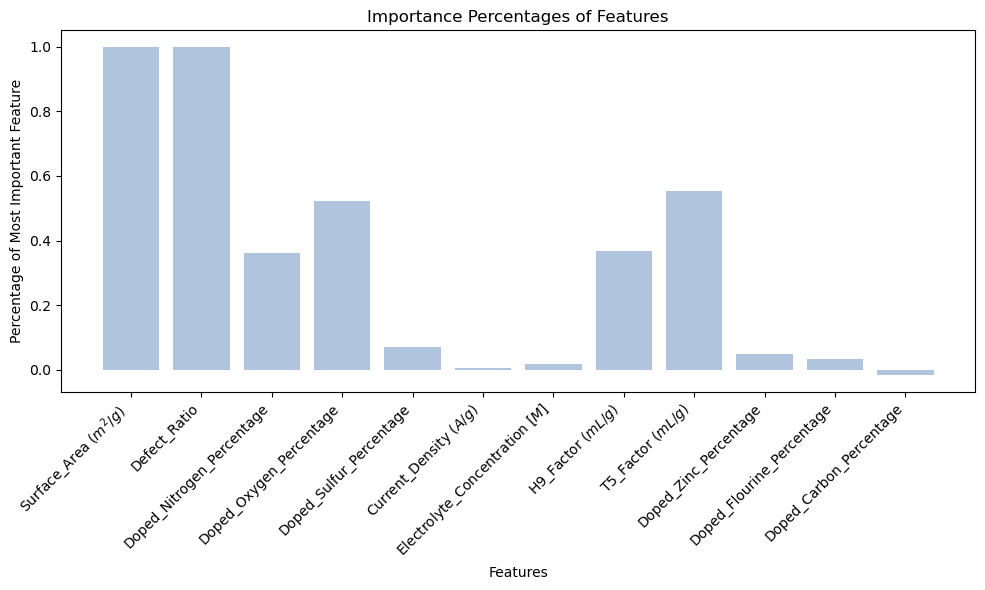

In [35]:
# bar chart of importance percentages
plt.figure(figsize=(10, 6))
plt.bar(feature_names, percentages, color='lightsteelblue')
plt.xlabel('Features')
plt.ylabel('Percentage of Most Important Feature')
plt.title('Importance Percentages of Features')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

The bar chart shows that the surface area contributes the most to the prediction of electrical capacity, with defect ratio pretty much contributing an equal amount.

Doped nitrogen percentage, doped oxygen percentage, H9 factor, and T5 factor also contribute a considerable amount, contributing between 35% and 60% of that of the surface area.

Comparatively, the remaining features have very little effect on the prediction of electrical capacity, with importance percentages of under 10%.



---



<a name="task-12"></a>

## (1.2) Multi-layer Perceptron [(index)](#index-task-12)

<a name="task-121"></a>

### (1.2.1) [(index)](#index-task-121)

In [36]:
def dense(X, W, b):
    """Full-connected MLP layer.
    Parameters:
        X (np.ndarray): K x h_in array of inputs, where K is the batch size and h_in if the input features dimension.
        W (np.ndarray): h_out x h_in array for kernel matrix parametersm, where h_out is the output dimension.
        b (np.ndarray): Length h_out 1-D array for bias parameters

    Returns:
        a (np.ndarray): K x h_out array of pre-activations
    """
    a = np.vstack([W @ x + b for x in X])
    return a

In [37]:
# define activation function given in question
def activation(a): 
    """activation function.

    Parameters:
        a: K x h_out array of pre-activations

    Returns:
        h: K x h_out array of post-activations
    """
    # compute post-activations
    h = np.arctan(a) * np.log(np.abs(a) + 1)
    return h

# define gradient of activation function given in question
def grad_activation(a): 
    """Gradient of activation function.

    Parameters:
        a: K x h_out array of pre-activations

    Returns:
        grad: K x h_out gradient array of post-activations
    """
    # compute gradient
    grad = (1 / (1 + a**2)) * np.log(np.abs(a) + 1) + np.arctan(a) * (1 / (np.abs(a) + 1)) * (a / np.abs(a))
    return grad

In [38]:
# lookup table for relevant activation functions
activation_table = {
    # Identity function.
    "identity": lambda x: x,
    "activation": activation
}

# lookup table for gradients of relevant activation functions
grad_activation_table = {
    # Identity function gradient.
    "identity": lambda x: np.ones_like(x),
    "activation": grad_activation
}

In [39]:
class MLP:
    """
    This class represents a Multi-Layer Perceptron (MLP), that we are going
    to use to encapsulate two components:
        1. layers: the sequence of layers, where each layer is stored in
            a dictionary in the format {"W": np.ndarray, "b": np.ndarray},
            where "W" points to the weights array, and "b" points to
            the bias vector.
        2. rng: a pseudo random number generator (RNG) initialised to generate
            the random weights in a reproducible manner between different
            runtime sessions.
    This class is also shipped with methods that perform essential operations
    with a MLP, including:
        - add_layers: which creates a new layer with specified dimensions.
        - predict: applies the MLP forward pass to make predictions and produces
            a computational graph for the forward pass that can be used to
            compute gradients using backpropagation algorithm.
        in addition to other light functions that return simple statistics about
        the MLP.
    """
    def __init__(self, seed=42):
        self.layers = []
        self.rng = np.random.default_rng(seed)

    def n_parameters(self):
        """Return the total number of parameters of weights and biases."""
        return sum(l["b"].size + l["W"].size for l in self.layers)

    def n_layers(self):
        """Return current number of MLP layers."""
        return len(self.layers)

    def layer_dim(self, index):
        """Retrieve the dimensions of the MLP layer at `index`."""
        return self.layers[index]["W"].shape

    def add_layer(self, in_dim, out_dim, activation="identity"):
        """Add fully connected layer to MLP.

        Parameters:
            in_dim (int): The output dimension of the layer.
            out_dim (int): The input dimension of the layer.
            activation (str): The activation function name.
        """
        # check if input-dimension matches output-dimension of previous layer
        if self.n_layers() > 0:
            last_out_dim, _ = self.layer_dim(-1)
            assert in_dim == last_out_dim, f"Input-dimension {in_dim} does not match output-dimension {last_out_dim} of previous layer."

        # the first layer, in our convention illustrated, does not apply activation on the input features X.
        if self.n_layers() == 0:
            assert activation == "identity", "Should not apply activations on the input features X, use Identity function for the first layer."

        # store each layer as a dictionary in the list, as shown in the
        # attached diagram.
        self.layers.append({
            # only for debugging.
            "index": len(self.layers),
            # apply Glorot initialisation for weights.
            "W": self.rng.normal(size=(out_dim, in_dim)) * np.sqrt(2. / (in_dim + out_dim)),
            # initialise bias vector with zeros.
            "b": np.zeros(out_dim), 
            # store the activation function (as string)
            "activation": activation,
            # initialise velocity for sgd with momentum.
            "V": (0,0)
        })

    def predict(self, X):
        """Apply the forward pass on the input X and produce prediction and the
        forward computation graph.
        Parameters:
            X (np.ndarray): Feature matrix.
        Returns:
            (np.ndarray, List[Dict[str, np.ndarray]]): A tuple of the
            predictions and the computation graph as a sequence of intermediate
            values through the MLP, specifically each layer will have a corresponding
            intermediate values {"a": np.ndarray, "h": np.ndarray}, as shown in the
            attached diagram above.
        """
        # we assume that we work with a batch of examples (ndim==2).
        if X.ndim == 1:
            # if one example passed, add a dummy dimension for the batch.
            X = X.reshape(1, -1)

        # store pre- and post-activations in list
        forward_pass = [{"index": 0, "a": X, "h": X}]

        # iterate through hidden layers
        for k in range(1, len(self.layers)):
            # compute pre-activations
            a = dense(forward_pass[k - 1]["h"], self.layers[k - 1]["W"], self.layers[k - 1]["b"])
            activation = activation_table[self.layers[k]["activation"]]
            forward_pass.append({"index": k, "a" : a, "h" : activation(a)})

        y_hat = dense(forward_pass[-1]["h"], self.layers[-1]["W"], self.layers[-1]["b"]) 
        # predicted target is output of last layer
        return y_hat, forward_pass

In [40]:
def mse_loss(y_true, y_pred):
    """Compute MSE-loss
    Parameters:
        y_true: ground-truth array, with shape (K, )
        y_pred: predictions array, with shape (K, )
    Returns:
        loss (float): MSE-loss
    """
    assert y_true.size == y_pred.size, "Ground-truth and predictions have different dimensions."

    # adjustment to avoid subtraction between (K,) and (1, K) arrays.
    y_true = y_true.reshape(y_pred.shape)

    return np.mean((y_true - y_pred)**2, keepdims=True)

In [41]:
def grad_mse_loss(y_true, y_pred):
    """Compute gradient of MSE-loss
    Parameters:
        y_true: ground-truth values, shape: (K, ).
        y_pred: prediction values, shape: (K, ).
    Returns:
        grad (np.ndarray): Gradient of MSE-loss, shape: (K, ).
    """
    # adjustment to avoid subtraction between (K,) and (1, K) arrays.
    y_true = y_true.reshape(y_pred.shape)

    return 2.0 * (y_pred - y_true) / y_true.size 

In [42]:
def backpropagate(layers, forward_pass, delta_output):
    """
    Apply the backpropagation algorithm to the MLP layers to compute the gradients starting from
    the output layer to the input layer, and starting the chain rule from the
    partial derivative of the loss function w.r.t the predictions $\hat{y}$. The

    Parameters:
        layers (List[Dict[str, np.ndarray]]): The MLP sequence of layers, as shown in the diagrams.
        forward_pass (List[Dict[str, np.ndarray]]): The forward pass intermediate values for
            each layer, representing a computation graph.
        delta_output (np.ndarray): the partial derivative of the loss function w.r.t the
            predictions $\hat{y}$, has the shape (K, 1), where K is the batch size.
    Returns:
        (List[Dict[str, np.ndarray]]): The computed gradient using a structure symmetric the layers, as shown
            in the diagrams.

    """
    # create a list that will contain the gradients of all the layers.
    delta = delta_output

    assert len(layers) == len(forward_pass), "Number of layers is expected to match the number of forward pass layers"

    # iterate on layers backwardly, from output to input.
    # calculate gradients w.r.t. weights and biases of each level and store in list of dictionaries.
    gradients = []
    for layer, forward_computes in reversed(list(zip(layers, forward_pass))):
        assert forward_computes["index"] == layer["index"], "Mismatch in the index."

        h = forward_computes["h"]
        assert delta.shape[0] == h.shape[0], "Mismatch in the batch dimension."


        gradients.append({"W" : delta.T @ h,
                          "b" : delta.sum(axis=0)}) 

        # update the delta for the next iteration
        grad_activation_f = grad_activation_table[layer["activation"]]
        grad_activation = grad_activation_f(forward_computes["a"])

        # calculate the delta for the backward layer.
        delta = np.stack([np.diag(gi) @ layer["W"].T @ di
                           for (gi, di) in zip(grad_activation, delta)])

    # return now ordered list matching the layers.
    return list(reversed(gradients))

In [43]:
def sgd_step(X, y, mlp, learning_rate = 5e-5):
    """
    Apply a stochastic gradient descent step using the sampled batch.
    Parameters:
        X (np.ndarray): The input features array batch, with dimension (K, D).
        y (np.ndarray): The ground-truth of the batch, with dimension (K, 1).
        mlp (MLP): The MLP object enacpsulating the MLP model.
        learning_rate (float): The learning rate multiplier for the update steps in SGD.
    Returns:
        (List[Dict[str, np.ndarray]]): The updated layers after applying SGD.
    """
    # Compute the forward pass.
    y_hat, forward_pass = mlp.predict(X)

    # Compute the partial derivative of the loss w.r.t. to predictions `y_hat`.
    delta_output = grad_mse_loss(y, y_hat) 

    # Apply backpropagation algorithm to compute the gradients of the MLP parameters.
    gradients = backpropagate(mlp.layers, forward_pass, delta_output)

    # mlp.layers and gradients are symmetric, as shown in the figure.
    updated_layers = []
    for layer, grad in zip(mlp.layers, gradients):
        W = layer["W"] - learning_rate * grad["W"] 
        b = layer["b"] - learning_rate * grad["b"] 
        updated_layers.append({"W": W, "b": b,
                               # keep the activation function.
                               "activation": layer["activation"],
                               # We use the index for asserts and debugging purposes only.
                               "index": layer["index"]})
    return updated_layers

In [44]:
def sgd(X_train, y_train, X_test, y_test, mlp, learning_rate = 5e-5,
        n_epochs=300, minibatchsize=8, seed=15):
    """
    Run the Stochastic Gradient Descent (SGD) algorithm to optimise the parameters of MLP model to fit it on
    the training data using MSE loss.
    Parameters:
        X_train (np.ndarray): The training data features, with shape (|D_train|, D).
        y_train (np.ndarray): The training data ground-truth, with shape (|D_train|, 1).
        X_test (np.ndarray): The testing data features, with shape (|D_test|, D).
        y_test (np.ndarray): The testing data ground-truth, with shape (|D_test|, 1).
        mlp (MLP): The MLP object enacpsulating the MLP model.
        learning_rate (float): The learning_rate multiplier used in updating the parameters at each iteration.
        n_epochs (int): The number of training cycles that each covers the entire training examples.
        minibatchsize (int): The batch size used in each SGD step.
        seed (int): A seed for the RNG to ensure reproducibility across runtime sessions.
    """
    # get random number generator
    rng = np.random.default_rng(seed)

    # compute number of iterations per epoch
    n_iterations = int(len(y_train) / minibatchsize)

    # store losses
    losses_train = []
    losses_test = []

    epochs_bar = tqdm(range(n_epochs))
    for i in epochs_bar:

        # shuffle data
        p = rng.permutation(len(y_train))
        X_train_shuffled = X_train[p]
        y_train_shuffled = y_train[p]

        for j in range(n_iterations):
            # get batch
            X_batch = X_train_shuffled[j*minibatchsize : (j+1)*minibatchsize]
            y_batch = y_train_shuffled[j*minibatchsize : (j+1)*minibatchsize]

            # apply sgd step
            updated_layers = sgd_step(X_batch, y_batch, mlp, learning_rate) 

            # update weights and biases of MLP
            mlp.layers = updated_layers

        # compute loss at the end of each epoch
        y_hat_train, _ = mlp.predict(X_train)
        losses_train.append(mse_loss(y_train, y_hat_train).squeeze())
        y_hat_test, _ = mlp.predict(X_test)
        losses_test.append(mse_loss(y_test, y_hat_test).squeeze())
        epochs_bar.set_description(f'train_loss: {losses_train[-1]:.2f}, '
                                   f'test_loss: {losses_test[-1]:.2f}, '
                                   f'train_R^2: {r2_score(y_train, y_hat_train):.2f} '
                                   f'test_R^2: {r2_score(y_test, y_hat_test):.2f} ')
    return mlp, losses_train, losses_test

In [45]:
# define the structure of the MLP
mlp = MLP(seed=15) # set seed for reproducible results
mlp.add_layer(12, 50) # input layer
mlp.add_layer(50, 50, "activation") # hidden layer 1 
mlp.add_layer(50, 50, "activation") # hidden layer 2 
mlp.add_layer(50, 1, "activation") # output layer

# print number of layers and number of trainable parameters in the MLP
print("Number of layers:", mlp.n_layers())
print("Number of trainable parameters:", mlp.n_parameters())

# train the MLP using stochastic gradient descent
mlp, losses_train, losses_test = sgd(X_train, np.array(y_train_df), X_test, np.array(y_test_df),
                                     mlp, learning_rate=5e-5,
                                     n_epochs=300,
                                     minibatchsize=8)

Number of layers: 4
Number of trainable parameters: 5801


  0%|          | 0/300 [00:00<?, ?it/s]

For the training data, we get an $R^2$ score of 0.91 and for the test data, we get an $R^2$ score of 0.54. This suggests that model performs reasonably well on unseen data but there is quite a bit of overfitting occuring since it performs significantly better on the training data.

Overall, the model is good and can make decently accurate predictions. To address overfitting, we could implement various regularisation techniques such as $l^2$ and $l^1$ regularisation, dropout, or early stopping.

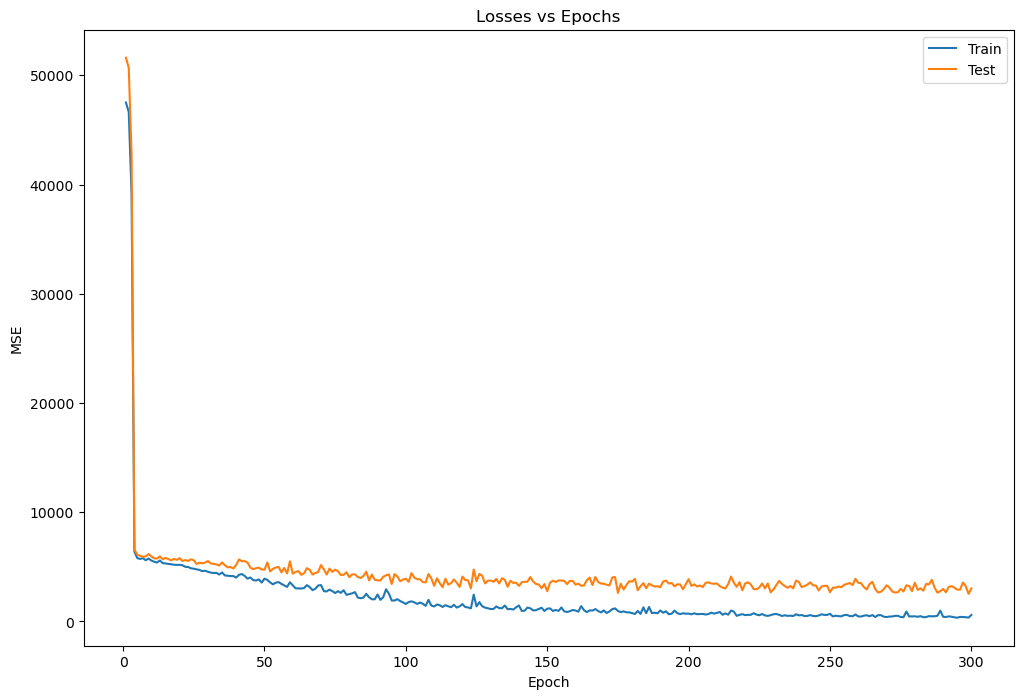

In [46]:
# plot training progress
n_epochs = 300
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(np.arange(1,n_epochs+1),losses_train, label="Train")
ax.plot(np.arange(1,n_epochs+1),losses_test, label="Test")
ax.set(title="Losses vs Epochs", xlabel = "Epoch", ylabel = "MSE")
ax.legend()
plt.show()

It is clear to see using the graph that the losses are converging, with the test losses converging quicker than the training losses.

In [47]:
# MSE of training and test data
losses_train[299], losses_test[299]

(array(594.9486687), array(3027.25099621))

For the training data, we get an MSE of 594.9 and for the test data, we get an MSE of 3027.3. Similar to the $R^2$, we find that the MLP performs significantly better on the training data than it does on the test data.

To conclude, the MLP does a relatively good job at making accurate predictions, however, there is a large amount of overfitting that is affecting them.

<a name="task-122"></a>

### (1.2.2) [(index)](#index-task-122)

We alter the sgd_step and sgd functions as well as the add_layer method in the MLP class, in order to use the SGD with momentum optimiser to train the MLP.

In [48]:
def sgd_step_momentum(X, y, mlp, learning_rate = 5e-5, beta=0.4):
    """
    Apply a stochastic gradient descent step with momentum using the sampled batch.
    Parameters:
        X (np.ndarray): The input features array batch, with dimensions (K, D).
        y (np.ndarray): The ground-truth of the batch, with dimensions (K, 1).
        mlp (MLP): The multi-layer perceptron model.
        learning_rate (float): The learning rate multiplier for the update steps in SGD. Default is 5e-5.
        beta (float): The momentum parameter, controlling the influence of the previous gradient steps.
                     Default is 0.4.
    Returns:
        (List[Dict[str, np.ndarray]]): The updated layers after applying SGD with momentum.
    """
    # compute the forward pass.
    y_hat, forward_pass = mlp.predict(X)

    # compute the partial derivative of the loss w.r.t. to predictions `y_hat`.
    delta_output = grad_mse_loss(y, y_hat)

    # apply backpropagation algorithm to compute the gradients of the MLP parameters.
    gradients = backpropagate(mlp.layers, forward_pass, delta_output)

    # mlp.layers and gradients are symmetric, as shown in the figure.
    updated_layers = []
    for layer, grad in zip(mlp.layers, gradients):
        # change learning_rate by adding momentum
        V = layer["V"]
        v_W, v_b = V
        v_W = beta*v_W + learning_rate * grad["W"]
        v_b = beta*v_b + learning_rate * grad["b"]
        W = layer["W"] - v_W 
        b = layer["b"] - v_b
        updated_layers.append({"W": W, "b": b, 
                               "V":(v_W, v_b),
                               # keep the activation function.
                               "activation": layer["activation"],
                               # We use the index for asserts and debugging purposes only.
                               "index": layer["index"]})
    return updated_layers

In [49]:
def sgd_momentum(X_train, y_train, X_test, y_test, mlp, learning_rate = 5e-5, beta=0.4,
        n_epochs=300, minibatchsize=8, seed=15):
    """
    Run the Stochastic Gradient Descent (SGD) algorithm to optimise the parameters of MLP model to fit it on
    the training data using MSE loss.
    Parameters:
        X_train (np.ndarray): The training data features, with shape (|D_train|, D).
        y_train (np.ndarray): The training data ground-truth, with shape (|D_train|, 1).
        X_test (np.ndarray): The testing data features, with shape (|D_test|, D).
        y_test (np.ndarray): The testing data ground-truth, with shape (|D_test|, 1).
        mlp (MLP): The MLP object encapsulating the MLP model.
        learning_rate (float): The learning rate multiplier used in updating the parameters at each iteration.
                               Default is 5e-5.
        beta (float): The momentum parameter, controlling the influence of the previous gradient steps.
                      Default is 0.4.
        n_epochs (int): The number of training cycles that each cover the entire training examples.
                        Default is 300.
        minibatchsize (int): The batch size used in each SGD step. Default is 8.
        seed (int): A seed for the random number generator to ensure reproducibility across runtime sessions.
                    Default is 15.
    Returns:
        Tuple: A tuple containing the trained MLP model, training losses, and testing losses.
    """
    # get random number generator
    rng = np.random.default_rng(seed)

    # compute number of iterations per epoch
    n_iterations = int(len(y_train) / minibatchsize)

    # store losses
    losses_train = []
    losses_test = []

    epochs_bar = tqdm(range(n_epochs))
    for i in epochs_bar:

        # shuffle data
        p = rng.permutation(len(y_train))
        X_train_shuffled = X_train[p]
        y_train_shuffled = y_train[p]

        for j in range(n_iterations):
            # get batch
            X_batch = X_train_shuffled[j*minibatchsize : (j+1)*minibatchsize]
            y_batch = y_train_shuffled[j*minibatchsize : (j+1)*minibatchsize]

            # apply sgd step with momentum
            updated_layers = sgd_step_momentum(X_batch, y_batch, mlp, learning_rate, beta)

            # update weights and biases of MLP
            mlp.layers = updated_layers 

        # compute loss at the end of each epoch
        y_hat_train, _ = mlp.predict(X_train)
        losses_train.append(mse_loss(y_train, y_hat_train).squeeze())
        y_hat_test, _ = mlp.predict(X_test)
        losses_test.append(mse_loss(y_test, y_hat_test).squeeze())
        epochs_bar.set_description(f'train_loss: {losses_train[-1]:.2f}, '
                                   f'test_loss: {losses_test[-1]:.2f}, '
                                   f'train_R^2: {r2_score(y_train, y_hat_train):.2f} '
                                   f'test_R^2: {r2_score(y_test, y_hat_test):.2f} ')
    return mlp, losses_train, losses_test

In [50]:
# define the structure of the MLP
mlp = MLP(seed=15) # set seed for reproducible results
mlp.add_layer(12, 50) # input layer
mlp.add_layer(50, 50, "activation") # hidden layer 1 
mlp.add_layer(50, 50, "activation") # hidden layer 2
mlp.add_layer(50, 1, "activation") # output layer

# print number of layers and number of trainable parameters in the MLP
print("Number of layers:", mlp.n_layers())
print("Number of trainable parameters:", mlp.n_parameters())

# train the MLP using stochastic gradient descent with momentum
mlp, losses_train, losses_test = sgd_momentum(X_train, np.array(y_train_df), X_test, np.array(y_test_df),
                                     mlp, learning_rate=5e-5, beta=0.4,
                                     n_epochs=300, minibatchsize=8)

Number of layers: 4
Number of trainable parameters: 5801


  0%|          | 0/300 [00:00<?, ?it/s]

For the training data, we get an $R^2$ score of 0.98 and for the test data, we get an $R^2$ score of 0.70. This suggests that model performs incredibly on seen data as 98% of the variance is explained. The overfitting has reduced drastically, as the $R^2$ score for the test data has increased by 0.16.

Overall, the model is great and can make very accurate predictions. Adding momentum to the stochastic gradient descent has had a very positive effect on both model training and performance.

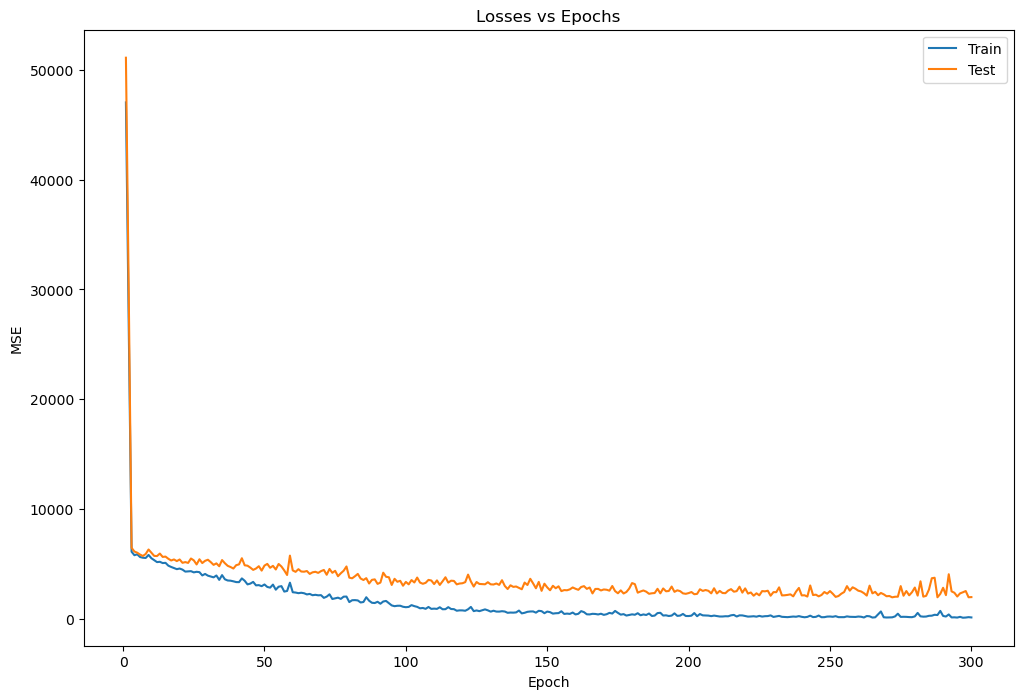

In [51]:
# plot training progress
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(np.arange(1,n_epochs+1),losses_train, label="Train")
ax.plot(np.arange(1,n_epochs+1),losses_test, label="Test")
ax.set(title="Losses vs Epochs", xlabel = "Epoch", ylabel = "MSE")
ax.legend()
plt.show()

It is clear to see using the graph that the losses are converging, with the test losses converging quicker than the training losses.

In [52]:
# MSE of training and test data
losses_train[299], losses_test[299]

(array(128.53808271), array(1979.34570871))

For the training data, we get an MSE of 128.5 and for the test data, we get an MSE of 1979.3. We can see that it has decreased a lot for both the training and test sets. It is almost $1/5$ of what it was without momentum for the training set, and almost $1/2$ of what it was for the test set.

These MSE values are very small and indicate that the MLP performs very well, especially for seen data.

The R^2 score for this model was 0.70 compared to 0.54 for the first MLP model and 0.52 for the random forest model.

The MSE for the this model was 1979 compared to 3027 for the first MLP model and 3148 for the random forest model.
 
We can conclude that the MLP with added momentum is the best model as it gives the most accurate predictions on the test set. The random forest model from 1.1.2 (without optimal max_depth and min_samples_leaf) appears to perform slightly worse than the MLP without added momentum but both give similar levels of accuracy.

<a name="task-123"></a>

### (1.2.3) [(index)](#index-task-123)

In [53]:
def extend(X):
    """
    Extend the features of the input dataset by computing pairwise products up to the 12th feature.
    """
    # convert X to list of columns
    X_list = list(X.T)
    
    # initialise list to store extended features
    extended_features = []
    
    # iterate over each pair of features
    for i in range(12):
        for j in range(i, 12):
            # multiply features and append to list
            extended_features.append(X_list[i] * X_list[j])
    
    # convert to numpy array and transpose to get correct shape
    X_extended = np.array(extended_features).T
    
    return X_extended

In [54]:
def augment(X):
    """
    Augment the input dataset by adding a column of ones at the beginning.
    """
    # compute number of samples and features
    N, D = X.shape
    
    # add column of ones
    X_augmented = np.hstack([np.ones((N, 1)), X])
    
    return X_augmented

In [55]:
# extend and augment the training set
X_train_extended = extend(X_train)
X_train_augmented = augment(X_train_extended)

# extend and augment the test set
X_test_extended = extend(X_test)
X_test_augmented = augment(X_test_extended)

In [56]:
def predict_with_estimate(X_test, beta):
    """Predict the target values using the test set and estimated coefficients."""
    prediction = X_test @ beta 
    return prediction

In [57]:
def ridge_estimate(X, y, penalty):
    """
    Estimate the coefficients of a ridge regression model.
    """
    # add bias term to input features
    N, D = X.shape
    X_aug = np.hstack([np.ones((N, 1)), X])  # augmented training inputs of size N x (D+1)

    # regularisation matrix with penalty excluding bias term
    I = np.identity(D + 1)
    I[0] = 0.0  # penalty excludes the bias term.

    # compute ridge regression coefficients
    beta_ridge = np.linalg.solve(X_aug.T @ X_aug + penalty * I, X_aug.T @ y)

    return beta_ridge

In [58]:
# test lambda = 0.001 on training and test sets
penalty_term = 0.001
beta_ridge = ridge_estimate(X_train_extended, y_train_df, penalty=penalty_term)

ridge_prediction_train = predict_with_estimate(X_train_augmented, beta_ridge)
print(f"R^2 of Ridge Regression on training set:", r2_score(np.array(y_train_df), ridge_prediction_train))
print(f"MSE of Ridge Regression on training set:", mean_squared_error(np.array(y_train_df), ridge_prediction_train))
print()

ridge_prediction_test = predict_with_estimate(X_test_augmented, beta_ridge)
print(f"R^2 of Ridge Regression on test set:", r2_score(np.array(y_test_df), ridge_prediction_test))
print(f"MSE of Ridge Regression on test set:", mean_squared_error(np.array(y_test_df), ridge_prediction_test))

R^2 of Ridge Regression on training set: 0.3116740090382756
MSE of Ridge Regression on training set: 4561.722236423147

R^2 of Ridge Regression on test set: 0.13652421044980556
MSE of Ridge Regression on test set: 5700.7500376194685


In [59]:
# test lambda = 1 on training and test sets
penalty_term = 1
beta_ridge = ridge_estimate(X_train_extended, y_train_df, penalty=penalty_term)

ridge_prediction_train = predict_with_estimate(X_train_augmented, beta_ridge)
print(f"R^2 of Ridge Regression on training set:", r2_score(np.array(y_train_df), ridge_prediction_train))
print(f"MSE of Ridge Regression on training set:", mean_squared_error(np.array(y_train_df), ridge_prediction_train))
print()

ridge_prediction_test = predict_with_estimate(X_test_augmented, beta_ridge)
print(f"R^2 of Ridge Regression on test set:", r2_score(np.array(y_test_df), ridge_prediction_test))
print(f"MSE of Ridge Regression on test set:", mean_squared_error(np.array(y_test_df), ridge_prediction_test))

R^2 of Ridge Regression on training set: 0.29140905084352375
MSE of Ridge Regression on training set: 4696.02358728166

R^2 of Ridge Regression on test set: 0.16441896337433204
MSE of Ridge Regression on test set: 5516.586201518496


In [60]:
# test lambda = 1000 on training and test sets
penalty_term = 1000
beta_ridge = ridge_estimate(X_train_extended, y_train_df, penalty=penalty_term)

ridge_prediction_train = predict_with_estimate(X_train_augmented, beta_ridge)
print(f"R^2 of Ridge Regression on training set:", r2_score(np.array(y_train_df), ridge_prediction_train))
print(f"MSE of Ridge Regression on training set:", mean_squared_error(np.array(y_train_df), ridge_prediction_train))
print()

ridge_prediction_test = predict_with_estimate(X_test_augmented, beta_ridge)
print(f"R^2 of Ridge Regression on test set:", r2_score(np.array(y_test_df), ridge_prediction_test))
print(f"MSE of Ridge Regression on test set:", mean_squared_error(np.array(y_test_df), ridge_prediction_test))

R^2 of Ridge Regression on training set: 0.20282289360097172
MSE of Ridge Regression on training set: 5283.107975549512

R^2 of Ridge Regression on test set: 0.14581757700796905
MSE of Ridge Regression on test set: 5639.394339640189


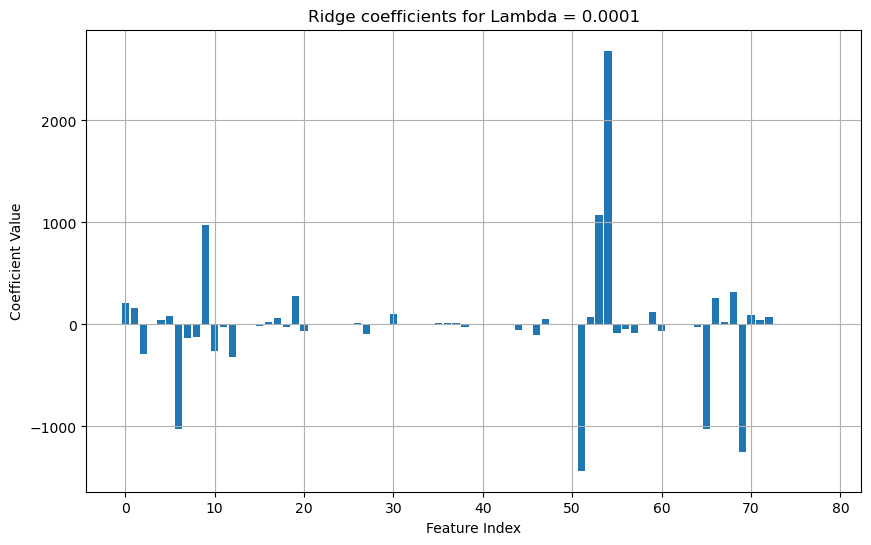

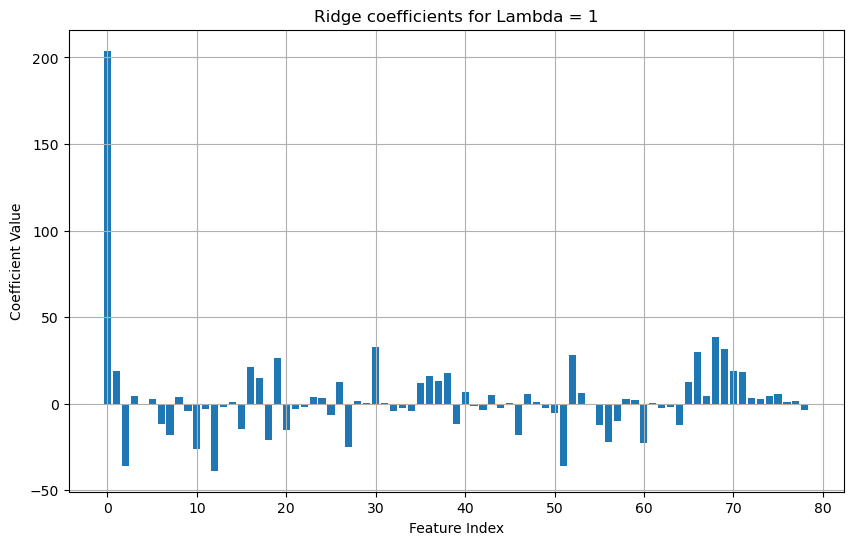

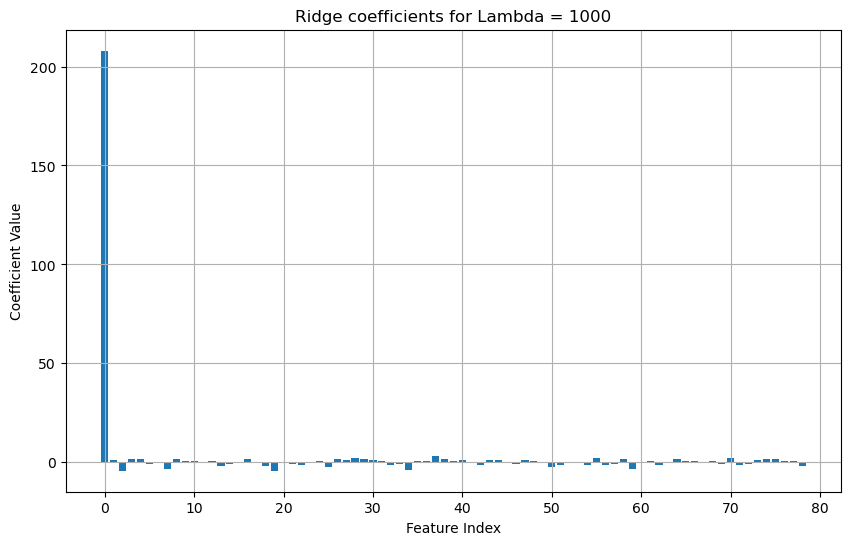

In [61]:
# define list of lambda values
lambdas = [0.0001, 1, 1000]

# iterate over each lambda value
for i, lambda1 in enumerate(lambdas):
    # compute ridge regression coefficients for extended set
    beta = ridge_estimate(X_train_extended, y_train_df, lambda1)

    # plotting
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(beta)), beta)
    plt.xlabel('Feature Index')
    plt.ylabel('Coefficient Value')
    plt.title(f'Ridge coefficients for Lambda = {lambda1}')
    plt.grid()
    plt.show()

We know that in ridge regression, the penalty term is appied to the sum of squared coefficients. This results in larger coefficients being penalised more heavily. We can see that in general, increasing $\lambda$ leads to lower coefficient values, in order to reduce overfitting. The exception to this is the intercept (feature index 0). This is due to the fact that it is not penalised by ridge regression.

In [62]:
def k_folds(X, k):
    """Partition the data into k folds for k-fold cross-validation."""
    # calculate fold sizes
    remainder = len(X) % k
    fold_sizes = [len(X) // k + 1 if i < remainder else len(X) // k for i in range(k)]

    # shuffle indices
    indices = np.arange(len(X))
    np.random.shuffle(indices)

    # split indices into folds
    folds = []
    current = 0
    for fold_size in fold_sizes:
        start, stop = current, current + fold_size
        folds.append(indices[start:stop])
        current = stop

    return folds

In [63]:
def cross_validation_ridge(X_train, y_train, folds, penalty):
    """Perform cross-validation for ridge regression."""
    # initialise scores
    scores = []
    
    # iterate over each fold
    for i in range(len(folds)):
        val_indexes = list(folds[i])
        val_indexes = [int(i) for i in val_indexes]
        train_indexes = list(set(range(y_train.shape[0])) - set(val_indexes))

        # split data into training and validation sets
        X_train_i = X_train[train_indexes, :]
        y_train_i = y_train[train_indexes]
        X_val_i = X_train[val_indexes, :] 
        y_val_i = y_train[val_indexes] 

        # augment validation set
        N, D = X_val_i.shape
        X_val_i = np.hstack([np.ones((N,1)), X_val_i])

        # compute ridge regression coefficients
        beta_ridge = ridge_estimate(X_train_i, y_train_i, penalty=penalty)

        # make predictions on validation set
        ridge_prediction = predict_with_estimate(X_val_i, beta_ridge)

        # compute mean squared error
        score_i = mean_squared_error(np.array(y_val_i), ridge_prediction)
        scores.append(score_i)

    # return average score
    return sum(scores) / len(scores)

In [64]:
# set seed for reproducability
np.random.seed(15)

lambdas = np.logspace(-4, 10, 100)
ridge_cross_validation_scores = []

for lambda1 in lambdas:
    score = cross_validation_ridge(X_train_extended, y_train_df, folds, lambda1)
    ridge_cross_validation_scores.append(score)

optimal_lambda = lambdas[np.argmin(ridge_cross_validation_scores)]
print(f"Optimal lambda: {optimal_lambda}")

Optimal lambda: 166.81005372000593


In [65]:
# test ridge regression with optimal lambda on training and test sets
penalty_term = optimal_lambda
beta_ridge = ridge_estimate(X_train_extended, y_train_df, penalty_term)

ridge_prediction_train = predict_with_estimate(X_train_augmented, beta_ridge)
print(f"R^2 of Ridge Regression on training set:", r2_score(np.array(y_train_df), ridge_prediction_train))
print(f"MSE of Ridge Regression on training set:", mean_squared_error(np.array(y_train_df), ridge_prediction_train))
print()

ridge_prediction_test = predict_with_estimate(X_test_augmented, beta_ridge)
print(f"R^2 of Ridge Regression on test set:", r2_score(np.array(y_test_df), ridge_prediction_test))
print(f"MSE of Ridge Regression on test set:", mean_squared_error(np.array(y_test_df), ridge_prediction_test))

R^2 of Ridge Regression on training set: 0.25923771742374724
MSE of Ridge Regression on training set: 4909.23170227864

R^2 of Ridge Regression on test set: 0.18583579613290502
MSE of Ridge Regression on test set: 5375.190216093443


In [66]:
# test ridge regression without ridge penalty on training and test sets
penalty_term = 0
beta_ridge = ridge_estimate(X_train_extended, y_train_df, penalty_term)

ridge_prediction_train = predict_with_estimate(X_train_augmented, beta_ridge)
print(f"R^2 of Ridge Regression on training set:", r2_score(np.array(y_train_df), ridge_prediction_train))
print(f"MSE of Ridge Regression on training set:", mean_squared_error(np.array(y_train_df), ridge_prediction_train))
print()

ridge_prediction_test = predict_with_estimate(X_test_augmented, beta_ridge)
print(f"R^2 of Ridge Regression on test set:", r2_score(np.array(y_test_df), ridge_prediction_test))
print(f"MSE of Ridge Regression on test set:", mean_squared_error(np.array(y_test_df), ridge_prediction_test))

R^2 of Ridge Regression on training set: 0.3129790411553509
MSE of Ridge Regression on training set: 4553.0734361368295

R^2 of Ridge Regression on test set: 0.11444710919659418
MSE of Ridge Regression on test set: 5846.505179017626


We notice that on the test set, ridge regression with the optimal ridge penalty outperforms regular linear regression (without a ridge penalty), as we would expect.

The $R^2$ of the model with the penalty is 0.182 compared to 0.114 without the penalty. This is quite a large difference in the amount of variance explained by the model.

The MSE of the model with the penalty is 5400 compared to 5847 without the penalty. These are relatively similar values and show there is quite a lot of error in both models.

Overall, both linear regression models perform poorly, with a low $R^2$ score and a high mean squared error. However, using an optimal penalty term improves the performance of the model.



---



<a name="task-2"></a>

# (2) Task 2: Classification [(index)](#index-task-2)

<a name="task-21"></a>

## (2.1) k-Nearest Neighbours [(index)](#index-task-21)

<a name="task-211"></a>

### (2.1.1) [(index)](#index-task-211)

We standardise the dataset using the convention discussed in the lecture. This makes it easier to compare the performance of different models.

In [67]:
def standardise(X, X_train_=None):
    """
    Standardise features.
    Parameters:
        X (np.array): Feature matrix.
        X_train_ (np.array): An optional feature matrix to compute the statistics
            from before applying it to X. If None, just use X to compute the statistics.
    Returns:
        X_std (np.array): Standardised feature matrix
    """
    if X_train_ is None:
        X_train_ = X

    mu = np.mean(X_train_, axis=0, keepdims=True)
    sigma = np.std(X_train_, axis=0, keepdims=True)
    X_std = (X - mu) / sigma
    return X_std

In [68]:
# training set data
cancer_samples = pd.read_csv('brain_cancer_samples.csv')
X_train_df = cancer_samples[cancer_samples.columns[np.arange(12)!=11]]
y_train_df = cancer_samples[cancer_samples.columns[-1]]

# transform training data into standardised arrays
X_train = standardise(np.array(X_train_df))[:,1:] # drop the Patient ID column
y_train = np.array(y_train_df)

# test set data, dropping the Patient ID column
cancer_test = pd.read_csv('brain_cancer_test.csv')
X_test_df = cancer_test[cancer_test.columns[np.arange(12)!=11]]
y_test_df = cancer_test[cancer_test.columns[-1]]

# transform test data into standardised arrays
X_test = standardise(np.array(X_test_df),np.array(X_train_df))[:,1:] # drop the Patient ID column
y_test = np.array(y_test_df)

# observe features
print(f'number of predictors = {X_test_df.shape[1]}')
X_test_df.head()

number of predictors = 11


,Patient ID,2D Surface,Contour Size,Total Surface,Density,Diameter,Primary Axis,Shape Variation,Location,Eccentricity_Real,Eccentricity_Imag
0,1,16.0,15.656854,16.5,0.969697,4.513517,4.654326,5.575232,1,4.040000e-17,0.659446
1,2,23651.5,1450.520980,38721.0,0.610818,173.533931,169.741043,236.322433,0,5.930000e-17,0.968694
2,3,10.5,18.727922,12.0,0.875000,3.656366,2.158408,8.873440,4,2.440000e-16,3.987627
3,4,3514.5,1242.673224,54204.5,0.064838,66.893949,291.385498,321.823425,3,2.870000e-17,0.468861
4,5,2127.5,300.492421,2910.0,0.731100,52.046298,47.092342,70.562317,3,6.830000e-17,1.115862


In [69]:
def euclidian_distance(p, q):
    """Compute the Euclidean distance between two sets of points."""
    return np.sqrt(np.sum((p-q)**2, axis=1))

In [70]:
def k_neighbours(X_train, X_test, k=5, return_distance=False):
    """Find the k nearest neighbours of each point in X_test from the points in X_train."""
    n_neighbours = k
    dist = []
    neigh_ind = []

    # compute distance from each point x_test in X_test to all points in X_train
    point_dist = [euclidian_distance(x_test, X_train) for x_test in X_test]

    # determine which k training points are closest to each test point
    for row in point_dist:
        enum_neigh = enumerate(row)
        sorted_neigh = sorted(enum_neigh, key=lambda x: x[1])[:k]
        ind_list = [tup[0] for tup in sorted_neigh]
        dist_list = [tup[1] for tup in sorted_neigh]
        dist.append(dist_list)
        neigh_ind.append(ind_list)

    # return distances together with indices of k nearest neighbours
    if return_distance:
        return np.array(dist), np.array(neigh_ind)

    return np.array(neigh_ind)

In [71]:
def predict(X_train, y_train, X_test, k=5):
    """
    Predict the labels for the test dataset using the k-nearest neighbours algorithm.
    """
    # find k nearest neighbours for each test point
    neighbours = k_neighbours(X_train, X_test, k=k)

    # predict labels based on majority vote of k nearest neighbours
    y_pred = np.array([np.argmax(np.bincount(y_train[neighbour])) for neighbour in neighbours])

    return y_pred

In [72]:
def score(X_train, y_train, X_test, y_test, k):
    """
    Compute the accuracy (micro-accuracy) score of a k-nearest neighbours classifier.
    """
    # predict labels for test set using k-nearest neighbours algorithm
    y_pred = predict(X_train, y_train, X_test, k=k)
    
    # compute accuracy 
    accuracy = float(sum(y_pred == y_test)) / float(len(y_test))
    
    return accuracy

In [73]:
# create a list of five index arrays, corresponding to each of the five folds.
folds_indexes = np.split(np.arange(len(y_train)), 5)

In [74]:
def cross_validation_score(X_train, y_train, folds, k):
    """
    Perform k-fold cross-validation to evaluate the performance of a k-nearest neighbours classifier.
    """
    # initialise scores
    scores = []
    
    # iterate over each fold
    for i in range(len(folds)):
        val_indexes = folds[i]
        train_indexes = list(set(range(y_train.shape[0])) - set(val_indexes))
        
        # separate training and validation data
        X_train_i = X_train[train_indexes, :]
        y_train_i = y_train[train_indexes]
        X_val_i = X_train[val_indexes, :]
        y_val_i = y_train[val_indexes]
        
        # train k-nearest neighbours classifier and evaluate its performance
        score_i = score(X_train_i, y_train_i, X_val_i, y_val_i, k=k)
        scores.append(score_i)

    # return average score
    return sum(scores) / len(scores)

In [75]:
def choose_best_k(X_train, y_train, folds, k_range):
    """
    Choose the best value of k for a k-nearest neighbours classifier using cross-validation.
    """
    # initialise scores
    k_scores = np.zeros((len(k_range),))
    
    # iterate over each k
    for i, k in enumerate(k_range):
        k_scores[i] = cross_validation_score(X_train, y_train, folds, k)
        print(f'CV_ACC@k={k}: {k_scores[i]:.3f}')

    # select k with highest cross-validation score
    best_k_index = np.argmax(k_scores)
    return k_range[best_k_index]

In [76]:
best_k = choose_best_k(X_train, y_train, folds_indexes, np.arange(1, 21))
print('Optimal value of k:', best_k)

CV_ACC@k=1: 0.648
CV_ACC@k=2: 0.662
CV_ACC@k=3: 0.745
CV_ACC@k=4: 0.676
CV_ACC@k=5: 0.738
CV_ACC@k=6: 0.703
CV_ACC@k=7: 0.690
CV_ACC@k=8: 0.724
CV_ACC@k=9: 0.690
CV_ACC@k=10: 0.676
CV_ACC@k=11: 0.683
CV_ACC@k=12: 0.648
CV_ACC@k=13: 0.662
CV_ACC@k=14: 0.655
CV_ACC@k=15: 0.683
CV_ACC@k=16: 0.662
CV_ACC@k=17: 0.648
CV_ACC@k=18: 0.655
CV_ACC@k=19: 0.641
CV_ACC@k=20: 0.628
Optimal value of k: 3


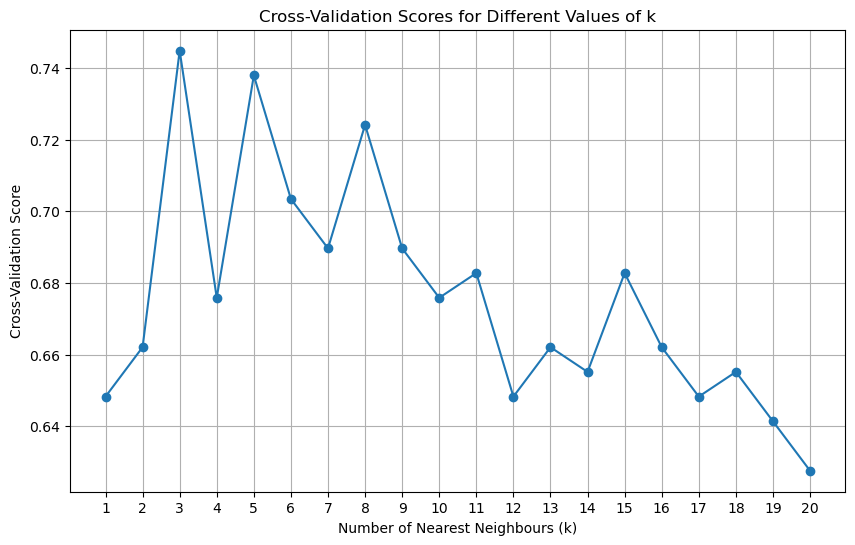

In [77]:
# define range of k values
k_values = np.arange(1, 21)

# compute cross-validation scores for each k
cross_val_scores = [cross_validation_score(X_train, y_train, folds_indexes, k) for k in k_values]

# plot graph
plt.figure(figsize=(10, 6))
plt.plot(k_values, cross_val_scores, marker='o', linestyle='-')
plt.title('Cross-Validation Scores for Different Values of k')
plt.xlabel('Number of Nearest Neighbours (k)')
plt.ylabel('Cross-Validation Score')
plt.xticks(k_values)
plt.grid(True)
plt.show()

In [78]:
# assess performance of optimal k on test set
print(f"Micro-averaged accuracy of kNN model on the test set: {score(X_train, y_train, X_test, y_test, best_k)}")

Micro-averaged accuracy of kNN model on the test set: 0.6666666666666666


In [79]:
# identify minority class
np.bincount(y_train), np.bincount(y_test)

(array([47, 80, 18]), array([18, 35,  7]))

The minority class is class 2 since there are only 18 values in that class for the training set and 7 values in that class for the test set, which is the least.

In [80]:
def confusion_matrix(y_true, y_pred, num_class):
    """
    Compute the confusion matrix for the classification task.
    Parameters:
        y_true (np.ndarray): The true labels with shape (N,).
        y_pred (np.ndarray): The predicted labels with shape (N,).
        num_class (int): The number of classes in the classification task.
    Returns:
        Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]: A tuple containing four arrays:
            - true_positives (TP) for each class.
            - true_negatives (TN) for each class.
            - false_positives (FP) for each class.
            - false_negatives (FN) for each class.
    """
    # initialise variables to store counts for each class
    true_positives = np.zeros(num_class, dtype=int)
    true_negatives = np.zeros(num_class, dtype=int)
    false_positives = np.zeros(num_class, dtype=int)
    false_negatives = np.zeros(num_class, dtype=int)
    
    # iterate over each class
    for class_ in range(num_class):
        # calculate true/false positives/negatives for the current class
        true_positives[class_] = np.sum((y_true == class_) & (y_pred == class_))
        true_negatives[class_] = np.sum((y_true != class_) & (y_pred != class_))
        false_positives[class_] = np.sum((y_true != class_) & (y_pred == class_))
        false_negatives[class_] = np.sum((y_true == class_) & (y_pred != class_))
    
    return true_positives, true_negatives, false_positives, false_negatives

In [81]:
def micro(true_positives, true_negatives, false_positives, false_negatives):
    """Compute micro-averaged accuracy and precision."""
    # calculate accuracy
    micro_accuracy = np.sum(true_positives) / (np.sum(true_positives) + 0.5 * (np.sum(false_positives) + np.sum(false_negatives)))
    
    # calculate precision
    micro_precision = np.sum(true_positives) / (np.sum(true_positives) + np.sum(false_positives))
    return micro_accuracy, micro_precision

In [82]:
def macro(true_positives, true_negatives, false_positives, false_negatives):
    """Compute macro-averaged accuracy and precision."""
    # calculate accuracy for each class
    class_accuracy = (true_positives + true_negatives) / (true_positives + true_negatives + false_positives + false_negatives)

    # calculate precision for each class
    class_precision = true_positives / (true_positives + false_negatives)

    # calculate macro-averaged accuracy
    macro_accuracy = np.mean(class_accuracy)

    # calculate macro-averaged precision
    macro_precision = np.mean(class_precision)

    return macro_accuracy, macro_precision

In [83]:
def class_weighted(true_positives, true_negatives, false_positives, false_negatives, weights):
    """Compute class-weighted accuracy and precision."""
    # calculate accuracy and precision for each class
    class_accuracy = (true_positives + true_negatives) / (true_positives + true_negatives + false_positives + false_negatives)
    class_precision = true_positives / (true_positives + false_negatives)

    # initialise class-weighted accuracy and precision
    class_weighted_accuracy, class_weighted_precision = 0, 0
    
    # calculate class-weighted accuracy and precision
    for i in range(len(weights)):
        class_weighted_accuracy += weights[i] * class_accuracy[i]
        class_weighted_precision += weights[i] * class_precision[i]
    
    return class_weighted_accuracy, class_weighted_precision

In [84]:
# predict labels for test set using k-nearest neighbours algorithm
y_pred_knn = predict(X_train, y_train, X_test, k=3)

# number of classes
num_class = 3

# compute confusion matrix
true_positives, true_negatives, false_positives, false_negatives = confusion_matrix(y_test, y_pred_knn, num_class)

# print confusion matrix values for each class
for class_ in range(num_class):
    print(f"Class {class_}:")
    print("True Positives:", true_positives[class_])
    print("True Negatives:", true_negatives[class_])
    print("False Positives:", false_positives[class_])
    print("False Negatives:", false_negatives[class_])
    print()

# micro-averaged accuracy and precision
micro_accuracy, micro_precision = micro(true_positives, true_negatives, false_positives, false_negatives)

# macro-averaged accuracy and precision
macro_accuracy, macro_precision = macro(true_positives, true_negatives, false_positives, false_negatives)

# class-weighted accuracy and precision
class_weighted_accuracy, class_weighted_precision = class_weighted(true_positives, true_negatives, false_positives, false_negatives, np.bincount(y_test)/len(y_test))

print(f"Micro-averaged accuracy: {micro_accuracy}")
print(f"Micro-averaged precision: {micro_precision}")
print("")

print(f"Macro-averaged accuracy: {macro_accuracy}")
print(f"Macro-averaged precision: {macro_precision}")
print("")

print(f"Class-weighted accuracy:{class_weighted_accuracy}")
print(f"Class-weighted precision:{class_weighted_precision}")
print("")

Class 0:
True Positives: 8
True Negatives: 35
False Positives: 7
False Negatives: 10

Class 1:
True Positives: 28
True Negatives: 12
False Positives: 13
False Negatives: 7

Class 2:
True Positives: 4
True Negatives: 53
False Positives: 0
False Negatives: 3

Micro-averaged accuracy: 0.6666666666666666
Micro-averaged precision: 0.6666666666666666

Macro-averaged accuracy: 0.7777777777777777
Macro-averaged precision: 0.6052910052910053

Class-weighted accuracy:0.7147222222222223
Class-weighted precision:0.6666666666666667



In [85]:
# accuracy of each class
class_accuracy = (true_positives + true_negatives) / (true_negatives + true_negatives + false_positives + false_negatives)

# accuracy of minority class (class 2)
minority_class_accuracy = class_accuracy[2]

# precision of each class
class_precision = true_positives / (true_positives + false_positives)

# precision of minority class (class 2)
minority_class_precision = class_precision[2]

print(f"Minority class accuracy: {minority_class_accuracy}")
print(f"Minority class precision: {minority_class_precision}")

Minority class accuracy: 0.5229357798165137
Minority class precision: 1.0


We can see that the micro-averaged accuracy is lower than the class-weighted accuracy and the macro-averaged accuracy is higher than the class-weighted accuracy. We can deduce from this that one class has much lower accuracy. 

Calculating the accuracy of the minority class, we find that it has an accuracy of 0.52 which is very low compared to the class-weighted accuracy, implying that the kNN classifier poorly predicts the minority class in comparison to the other two classes (there are many false positives and false negatives).

Calculating the precision of the minority class, we find that it has a precision of 1.0. This tells us that when the classifier predicts an instance as belonging to the minority class, it is always correct (there are no false positives).

Overall, the kNN classifier doesn't do too bad on the test set, with values above 0.6 for all six metrics. The minority class has a much higher precision than the other two classes but a much lower accuracy, meaning the kNN classifier doesn't do too well at predicting the minority class.

<a name="task-212"></a>

### (2.1.2) [(index)](#index-task-212)

This weighting strategy gives more weight to smaller classes, multiplying by a factor inversely proportional to the frequency of the class. Closer neighbours are also given more weight. The aim of this strategy is to improve the prediction of the minority class by giving it more weight.

In [86]:
def weighted_predict(X_train, y_train, X_test, k=3):
    """
    Predict class labels for test data using a weighted k-nearest neighbours (kNN) algorithm.
    """
    # find k nearest neighbours for each test point
    distances, neighbours = k_neighbours(X_train, X_test, k=k, return_distance=True)
    
    # initialise array to store weighted votes for each class
    weighted_votes = np.zeros((X_test.shape[0], np.max(y_train) + 1))
    
    # iterate over each test point
    for i, neighbour_indices in enumerate(neighbours):
        # get corresponding labels of k nearest neighbours
        neighbour_labels = y_train[neighbour_indices]
    
        # calculate weights for each neighbour based on their distance and class frequency
        weights = np.zeros_like(neighbour_labels, dtype=float)
        for j, label in enumerate(neighbour_labels):
            # calculate the frequency of the specific class label within the neighbourhood
            class_frequency = np.sum(neighbour_labels[:j+1] == label) 
            # assign weights inversely proportional to class frequency
            weights[j] = 1 / (distances[i, j] + 1e-6) * (1 / (class_frequency + 1e-6))
        
        # accumulate weighted votes for each class
        for j, label in enumerate(neighbour_labels):
            weighted_votes[i, label] += weights[j]
    
    # predict class with maximum weighted vote for each test point
    y_pred = np.argmax(weighted_votes, axis=1)
    
    return y_pred

In [87]:
def weighted_score(X_train, y_train, X_test, y_test, k=3):
    """
    Compute the accuracy score of predictions made by the weighted k-nearest neighbours (kNN) algorithm.
    """
    y_pred = weighted_predict(X_train, y_train, X_test, k=k)
    return float(sum(y_pred == y_test)) / float(len(y_test))


In [88]:
def weighted_cross_validation_score(X_train, y_train, folds, k):
    """
    Compute the cross-validation score using the weighted k-nearest neighbours (kNN) algorithm.
    """
    scores = []
    for i in range(len(folds)):
        val_indexes = folds[i]
        train_indexes = list(set(range(y_train.shape[0])) - set(val_indexes))

        X_train_i = X_train[train_indexes, :]
        y_train_i = y_train[train_indexes]
        X_val_i = X_train[val_indexes, :] 
        y_val_i = y_train[val_indexes] 

        # compute score using weighted kNN
        score_i = weighted_score(X_train_i, y_train_i, X_val_i, y_val_i, k=k) 
        scores.append(score_i)

    # Return the average score
    return sum(scores) / len(scores)

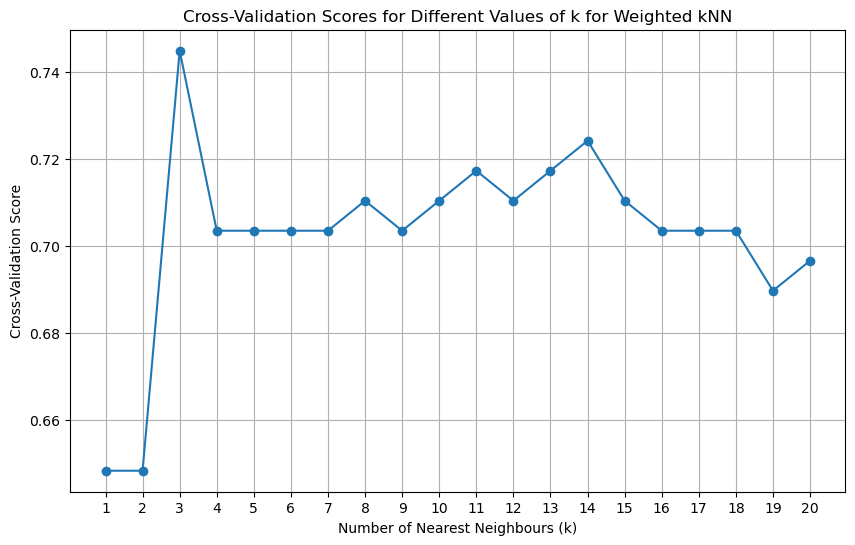

In [89]:
# define range of k values
k_values = np.arange(1, 21)

# compute cross-validation scores for each k
cross_val_scores = [weighted_cross_validation_score(X_train, y_train, folds_indexes, k) for k in k_values]

# plot graph
plt.figure(figsize=(10, 6))
plt.plot(k_values, cross_val_scores, marker='o', linestyle='-')
plt.title('Cross-Validation Scores for Different Values of k for Weighted kNN')
plt.xlabel('Number of Nearest Neighbours (k)')
plt.ylabel('Cross-Validation Score')
plt.xticks(k_values)
plt.grid(True)
plt.show()

In [90]:
# predict labels for test set using k-nearest neighbours algorithm
y_weighted_pred = weighted_predict(X_train, y_train, X_test, k=3)

# number of classes
num_class = 3

# compute confusion matrix
true_positives, true_negatives, false_positives, false_negatives = confusion_matrix(y_test, y_weighted_pred, num_class)

# print confusion matrix values for each class
for class_ in range(num_class):
    print(f"Class {class_}:")
    print("True Positives:", true_positives[class_])
    print("True Negatives:", true_negatives[class_])
    print("False Positives:", false_positives[class_])
    print("False Negatives:", false_negatives[class_])
    print()

# micro-averaged accuracy and precision
micro_accuracy, micro_precision = micro(true_positives, true_negatives, false_positives, false_negatives)

# macro-averaged accuracy and precision
macro_accuracy, macro_precision = macro(true_positives, true_negatives, false_positives, false_negatives)

# class-weighted accuracy and precision
class_weighted_accuracy, class_weighted_precision = class_weighted(true_positives, true_negatives, false_positives, false_negatives, np.bincount(y_test)/len(y_test))

print(f"Micro-averaged accuracy: {micro_accuracy}")
print(f"Micro-averaged precision: {micro_precision}")
print("")

print(f"Macro-averaged accuracy: {macro_accuracy}")
print(f"Macro-averaged precision: {macro_precision}")
print("")

print(f"Class-weighted accuracy:{class_weighted_accuracy}")
print(f"Class-weighted precision:{class_weighted_precision}")
print("")

Class 0:
True Positives: 10
True Negatives: 35
False Positives: 7
False Negatives: 8

Class 1:
True Positives: 29
True Negatives: 14
False Positives: 11
False Negatives: 6

Class 2:
True Positives: 3
True Negatives: 53
False Positives: 0
False Negatives: 4

Micro-averaged accuracy: 0.7
Micro-averaged precision: 0.7

Macro-averaged accuracy: 0.8000000000000002
Macro-averaged precision: 0.6042328042328042

Class-weighted accuracy:0.7519444444444444
Class-weighted precision:0.7000000000000001



In [91]:
# accuracy of each class
class_accuracy = (true_positives + true_negatives) / (true_negatives + true_negatives + false_positives + false_negatives)

# accuracy of minority class (class 2)
minority_class_accuracy = class_accuracy[2]

# precision of each class
class_precision = true_positives / (true_positives + false_positives)

# precision of minority class (class 2)
minority_class_precision = class_precision[2]

print(f"Minority class accuracy: {minority_class_accuracy}")
print(f"Minority class precision: {minority_class_precision}")

Minority class accuracy: 0.509090909090909
Minority class precision: 1.0


We find that all six metrics have improved compared to the values in 2.1.1, meaning the weighted kNN model is more effective at making predictions than the unweighted one. We obtain fewer false positives and false negatives using the weighted model.

Observing the minority class spefically, we find that the minority class accuracy is very similar, and the minority class precision is still 1.0. 

Therefore, the weighted kNN model is much better overall, however, it is not much more effective at predicting the minority class. A different weighting strategy may be more appropriate.

<a name="task-213"></a>

### (2.1.3) [(index)](#index-task-213)

In [92]:
# merge classes 1 and 2 into class 1 (malignant tumor diagnosis)
y_train_binary = np.where(y_train == 0, 0, 1)

def predict_binary1(X_train, y_train, X_test, k1 = best_k):
    """
    Train a kNN model where where the two classes are ‘benign tumour diagnosis’ (class 0)
    and ‘malignant tumour diagnosis’ (classes 1 and 2 combined).
    """
    # prediction for y_test_binary
    y_pred1 = predict(X_train, y_train_binary, X_test, k = k1)
    return y_pred1

def predict_binary2(X_train, y_train, X_test, k2 = 1):
    """
    Perform a 2-step binary classification for the original three-class classification problem.
    """
    y_pred1 = predict(X_train, y_train_binary, X_test, best_k)
    
    # modify training and testing data
    X_test_modified = X_test[y_pred1 == 1]
    X_train_modified = X_train[y_train_binary == 1]
    y_train_modified = y_train[y_train_binary == 1]
    
    # prediction for y_test
    y_pred2 = y_pred1.copy()
    y_pred2[y_pred1 == 1] = predict(X_train_modified, y_train_modified, X_test_modified, k = k2)
    return y_pred2

In [93]:
# predict labels for test set using k-nearest neighbours algorithm
y_pred_binary = predict_binary2(X_train, y_train, X_test, k2 = 1)

# number of classes
num_class = 3

# compute confusion matrix
true_positives, true_negatives, false_positives, false_negatives = confusion_matrix(y_test, y_pred_binary, num_class)

# print confusion matrix values for each class
for class_ in range(num_class):
    print(f"Class {class_}:")
    print("True Positives:", true_positives[class_])
    print("True Negatives:", true_negatives[class_])
    print("False Positives:", false_positives[class_])
    print("False Negatives:", false_negatives[class_])
    print()

# micro-averaged accuracy and precision
micro_accuracy, micro_precision = micro(true_positives, true_negatives, false_positives, false_negatives)

# macro-averaged accuracy and precision
macro_accuracy, macro_precision = macro(true_positives, true_negatives, false_positives, false_negatives)

# class-weighted accuracy and precision
class_weighted_accuracy, class_weighted_precision = class_weighted(true_positives, true_negatives, false_positives, false_negatives, np.bincount(y_test)/len(y_test))

print(f"Micro-averaged accuracy: {micro_accuracy}")
print(f"Micro-averaged precision: {micro_precision}")
print("")

print(f"Macro-averaged accuracy: {macro_accuracy}")
print(f"Macro-averaged precision: {macro_precision}")
print("")

print(f"Class-weighted accuracy:{class_weighted_accuracy}")
print(f"Class-weighted precision:{class_weighted_precision}")
print("")

Class 0:
True Positives: 8
True Negatives: 35
False Positives: 7
False Negatives: 10

Class 1:
True Positives: 28
True Negatives: 13
False Positives: 12
False Negatives: 7

Class 2:
True Positives: 5
True Negatives: 53
False Positives: 0
False Negatives: 2

Micro-averaged accuracy: 0.6833333333333333
Micro-averaged precision: 0.6833333333333333

Macro-averaged accuracy: 0.7888888888888889
Macro-averaged precision: 0.652910052910053

Class-weighted accuracy:0.7263888888888889
Class-weighted precision:0.6833333333333335



We find that the 2-step kNN performs very well, but not as well as the weighted version of kNN from 2.1.2. 

Weighted kNN has the best score for all six metrics. 2-step kNN has the second best for all six metrics, and unweighted kNN performs the worst for all six metrics. However, the scores for each model are relatively close.

We would expect weighted kNN to perform very well as it is able to make more informed classification decisions, especially considering the fact that the classes differ greatly in size.

2-step kNN might perform worse than weighted kNN due to the loss of information from separating the classification into two separate binary classification tasks.

Unweighted kNN may perform the worst since it treats all neighbours equally, resulting in outliers having a big effect on the accuracy of the model. It also prioritises the majority class, leading to predictions with lower accuracy and bias, especially for the minority class.



---



<a name="task-22"></a>

## (2.2) Logistic regression vs kernel logistic regression [(index)](#index-task-22)

<a name="task-221"></a>

### (2.2.1) [(index)](#index-task-221)

In [94]:
# formulation of the binary classification task
y_train_binary = np.where(y_train == 0, 0, 1)
y_test_binary = np.where(y_test == 0, 0, 1)

In [95]:
def logistic(z):
    """Compute the logistic sigmoid function."""
    return 1. / (1. + np.exp(-z))

In [96]:
def predict_log(X, beta):
    """Predict the probability of belonging to a class using logistic regression."""
    y_log = logistic(X @ beta)
    return y_log.squeeze()

In [97]:
def initialise(size):
    """ 
    Initialise beta parameter.
    Argument:
    size: Size of the parameter vector beta
    Returns:
    beta: Initialised vector of shape (size, 1)
    """
    beta = np.zeros((size, 1))
    return beta

In [98]:
def propagate(X, y, beta, lambda1=0.0025):
    """
    Compute the mean sample loss and its gradient with respect to beta.
    Arguments:
    X: Data of shape (N, p+1)
    y: True label vector of size N
    beta: Parameter vector, a numpy array of size p+1
    lambda1: Regularisation parameter for the magnitude of beta
    Returns:
    mean_loss: Mean sample loss for the negative log-likelihood
    dbeta: Gradient of the mean sample loss with respect to beta
    """
    y_log = predict_log(X, beta)

    # mean sample loss function
    mean_loss = - np.mean(y * np.log(y_log) + (1-y) * np.log(1 - y_log) + lambda1/2 * np.linalg.norm(beta) ** 2)

    # derivatives
    dbeta = np.mean(X.T * (y_log - y), axis=1).reshape(-1, 1)
    dbeta += lambda1 * beta
    
    mean_loss = np.squeeze(mean_loss)
    
    # store gradients in a dictionary
    grads = {'dbeta': dbeta}
      
    return grads, mean_loss

In [99]:
def optimise(X, y, beta, num_iterations=1000, learning_rate=0.1, print_loss=False):
    """
    Optimise the logistic regression parameters using gradient descent.
    Arguments:
    X: Data of shape (N, p+1)
    y: True label vector of size N
    beta: Parameter vector, a numpy array of size p+1
    num_iterations: Number of iterations
    learning_rate: Step size in updating procedure
    print_loss: 'True' to print the mean loss every 100 iterations
    Returns:
    params: Dictionary containing the parameter vector beta
    grads: Dictionary containing the gradient
    mean_loss_history: List of all the mean loss values computed during the optimisation (can be used to plot the learning curve)
    """
    mean_loss_history = []
    
    for i in range(num_iterations):

        # calculating the loss and gradients 
        grads, mean_loss = propagate(X, y, beta)
        
        # retrieving derivatives from grads
        dbeta = grads['dbeta']
        
        # updating procedure
        beta = beta - learning_rate * dbeta 
        
        # record the loss values
        if i % 100 == 0:
            mean_loss_history.append(mean_loss)
        
        # printing the loss every 100 iterations
        if print_loss and i % 100 == 0:
            print ('Mean loss after iteration %i: %f' %(i, mean_loss))
    
    # saving parameters and gradients in dictionary
    params = {'beta': beta}
    grads = {'dbeta': dbeta}
    
    return params, grads, mean_loss_history

In [100]:
def predict(X_test, beta):
    """
    Predict the binary class labels for the test set using logistic regression.
    Arguments:
    X_test: Test set of shape (N_test, p+1)
    beta: Parameter vector, a numpy array of size p+1
    Returns:
    y_pred: Vector containing all binary predictions (0/1) for X_test
    """
    N_test = X_test.shape[0]
    y_pred = np.zeros((N_test, 1))
    beta = beta.reshape(X_test.shape[1], 1)
    
    # predicting the probabilities
    y_log = predict_log(X_test, beta)
    
    y_pred = y_log.round().reshape(1, -1)
    
    return y_pred

In [101]:
def model(X_train, y_train, X_test, y_test, num_iterations=2000, learning_rate=0.1, print_loss=False):
    """Train the logistic regression model and evaluate on the training and test set."""
    # initialising parameters with zeros
    beta = initialise(X_train.shape[1])

    # gradient descent
    parameters, grads, mean_loss_history = optimise(X_train, y_train, beta, num_iterations, learning_rate, print_loss=print_loss)

    # retrieving parameter vector beta from dictionary 'parameters'
    beta = parameters['beta']

    # predicting test and training set examples
    y_pred_test = predict(X_test, beta)
    y_pred_train = predict(X_train, beta)

    # printing train/test accuracy
    print('Training accuracy: {} %'.format(100 - np.mean(np.abs(y_pred_train - y_train)) * 100))
    print('Test accuracy: {} %'.format(100 - np.mean(np.abs(y_pred_test - y_test)) * 100))

    # saving all information
    d = {'mean_loss_history': mean_loss_history, 'y_pred_test': y_pred_test, 'y_pred_train': y_pred_train, 'beta': beta, 'learning_rate': learning_rate, 'num_iterations': num_iterations}
    
    return d

In [102]:
# running the model
d = model(X_train, y_train_binary, X_test, y_test_binary, num_iterations=500, learning_rate=0.1, print_loss=True)

Mean loss after iteration 0: 0.693147
Mean loss after iteration 100: 0.623937
Mean loss after iteration 200: 0.616954
Mean loss after iteration 300: 0.612943
Mean loss after iteration 400: 0.610708
Training accuracy: 64.82758620689656 %
Test accuracy: 56.666666666666664 %


In [103]:
def precision_recall_curve(y_true, y_log):
    """
    Arguments:
    y_true: Ground truth labels with size N
    y_log: Probabilities produced by logistic regression model with size N
  
    Returns:
    auc: Area Under the Curve (AUC) of the precision-recall curve
    precision_l: List of precision values for each scanned threshold
    recall_l: List of recall values for each scanned threshold
    thresholds: Scanned thresholds sorted in decreasing order
    """
    thresholds = reversed(sorted(set(y_log)))
    precision_l, recall_l = [], []

    for threshold in thresholds:
        y_thresholded = (y_log >= threshold)

        tp = np.sum(y_true & y_thresholded)
        fp = np.sum((~y_true) & y_thresholded)
        fn = np.sum(y_true & (~y_thresholded))

        precision = tp / (tp + fp)
        recall = tp / (tp + fn) 

        precision_l.append(precision)
        recall_l.append(recall)
    
    # compute AUC-PR using Trapezoidal rule
    auc = np.trapz(precision_l, recall_l)
    
    return auc, precision_l, recall_l, thresholds

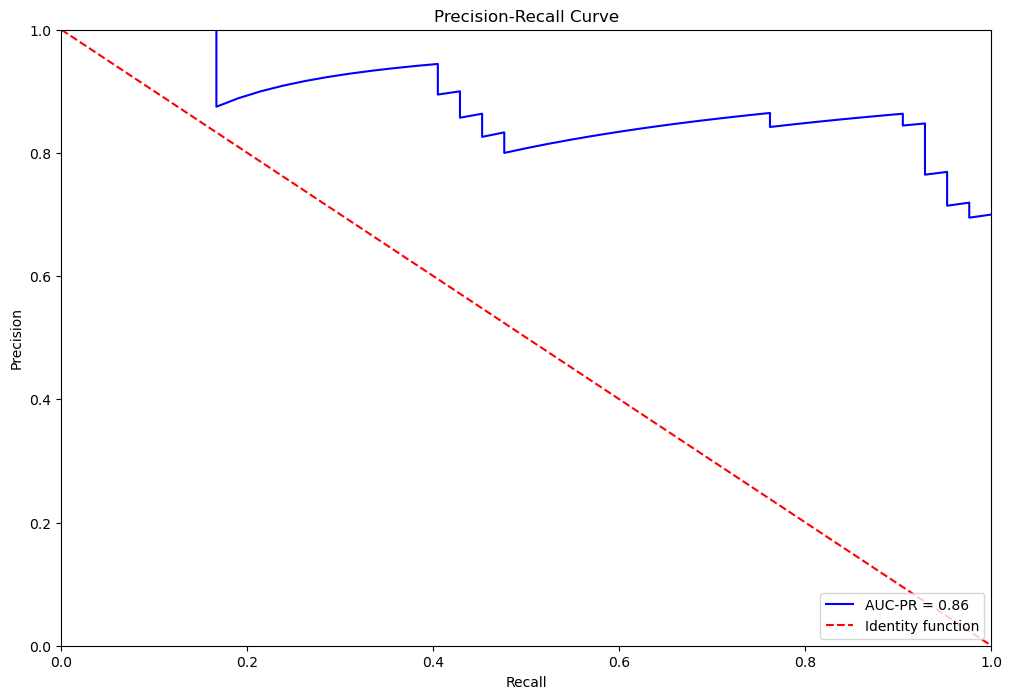

In [104]:
y_log = predict_log(X_test, d['beta'])
auc, precision, recall, th = precision_recall_curve(y_test_binary, y_log) 

plt.figure(figsize=(12,8))
plt.title(f'Precision-Recall Curve')
plt.plot(recall, precision, 'b', label=f'AUC-PR = {auc:0.2f}')
plt.plot([0, 1], [1,0], 'r--', label='Identity function')
plt.legend(loc='lower right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

An AUC-PR of 0.86 suggests that the model has achieved a very good balance between precision and recall, meaning it is able to distinguish between the two classes very well. This implies that the model can both identify a large portion of positive instances (recall) and also that false positives are rare (precision). 

Therefore, this suggests that the model has a a high generalising power and can effectively predict unseen data, even when the dataset is imbalanced.

<a name="task-222"></a>

### (2.2.2) [(index)](#index-task-222)

In [105]:
def kernel_mat(X, Y, alpha):
    """
    Compute the kernel matrix using the Laplacian kernel.
    Parameters:
    - X (numpy.ndarray): Input matrix of shape (x, _).
    - Y (numpy.ndarray): Input matrix of shape (y, _).
    - alpha (float): Parameter controlling the shape of the kernel.
    Returns:
    - kernel (numpy.ndarray): Kernel matrix of shape (x, y).
    """
    # get number of rows in each input matrix
    x, _ = X.shape
    y, _ = Y.shape
    
    # initialise kernel matrix
    kernel = np.zeros((x, y))

    # compute kernel values using Laplacian kernel given in question
    for i in range(x):
        # compute L1 distance between current row of X and all rows of Y
        distances = np.linalg.norm(Y - X[i], ord=1, axis=1)
        # compute kernel values
        kernel[i, :] = np.exp(-distances * alpha)

    return kernel

In [106]:
def kernelised_predict_log(A, beta, intercept):
    """
    Predict the probability of belonging to a class using logistic regression applied to a kernel matrix.
    """
    y_log = logistic((A @ np.array(beta)) + intercept)
    return y_log.squeeze()

We construct the loss function: 

$E(L) = -\frac{1}{N} \sum (y^{(i)} log(h_{u,u_{0}}(x^{(i)})) + (1-y^{(i)}) log(1-h_{u,u_{0}}(x^{(i)})) + \frac{\lambda}{2} u^T A u$

$h_{u,u_{0}}(x) := \frac{1}{1 + e^{-(A u + u_{0})}}$ 

where A is the kernel matrix computed using the Laplacian kernel.

In [107]:
def kernelised_propagate(A, y, beta, intercept, lambda1 = 0.0025):
    """
    Compute the mean sample loss and its gradient for logistic regression applied to a kernel matrix.
    """
    y_log = kernelised_predict_log(A, beta, intercept)

    # mean sample loss function
    mean_loss = - np.mean(y * np.log(y_log) + (1-y) * np.log(1 - y_log)) + lambda1/2 * np.dot(beta.T, A @ beta)

    # derivatives
    dbeta = np.mean(A.T * (y_log - y) , axis=1).reshape(-1, 1) + lambda1 * A @ beta
    dintercept = np.mean((y_log - y)) 

    mean_loss = np.squeeze(mean_loss)
    
    # store gradients in a dictionary
    grads = {'dbeta': dbeta, "dintercept" : dintercept}
    
    return grads, mean_loss

In [108]:
def kernelised_optimise(A, y, beta, num_iterations=1000, learning_rate=0.1, print_loss=False):
    """
    Optimise the kernelised version of logistic regression parameters using gradient descent.
    """
    mean_loss_history = []
    intercept = 0
    
    for i in range(num_iterations):

        # calculating loss and gradients
        grads, mean_loss = kernelised_propagate(A, y, beta, intercept)
        
        # retrieving derivatives from grads
        dbeta = grads['dbeta']
        dintercept = grads['dintercept']

        # updating procedure
        beta = beta - learning_rate * dbeta
        intercept = intercept - learning_rate * dintercept

        # record loss values
        if i % 100 == 0:
            mean_loss_history.append(mean_loss)

        # printing loss every 100 iterations
        if print_loss and i % 100 == 0:
            print ('Mean loss after iteration %i: %f' %(i, mean_loss))

    # saving parameters and gradients in dictionary
    params = {'beta': beta, "intercept": intercept}
    grads = {'dbeta': dbeta, "dintercept" : dintercept}

    return params, grads, mean_loss_history

We analyse the loss function component by component. The logistic loss component is the negative log-likelihood of the logistic regression model, which is convex.

The regularisation component, given by $\frac{\lambda}{2} u^T A u$, is a quadratic function of $u$, and since the kernel matrix is positive definite, this component is convex.

Since both components of the loss function are convex, the overall loss function is convex since summing two convex functions is convex. Therefore, optimising our loss function is a convex optimisation problem.

<a name="task-223"></a>

### (2.2.3) [(index)](#index-task-223)

In [109]:
def kernelised_predict(X_test, beta, intercept):
    """
    Predict the class labels for a given test set using kernelised logistic regression.
    """
    N_test = X_test.shape[0]
    y_pred = np.zeros((N_test, 1))
    beta = beta.reshape(X_test.shape[1], 1)
    
    # Predicting the probabilities
    y_log = kernelised_predict_log(X_test, beta, intercept)
    
    y_pred = y_log.round().reshape(1, -1) 

    return y_pred

In [110]:
def kernelised_model(X_train, y_train, X_test, y_test, alpha, num_iterations=2000, learning_rate=0.1, print_loss=False):
    """
    Train and evaluate a kernelised logistic regression model using Laplacian kernel.
    """
    A_train = kernel_mat(X_train, X_train, alpha)
    A_test = kernel_mat(X_test, X_train, alpha)
    
    # initialising parameters with zeros
    beta = initialise(A_train.shape[1])

    # gradient descent
    parameters, grads, mean_loss_history = kernelised_optimise(A_train, y_train, beta, num_iterations, learning_rate, print_loss=print_loss)

    # retrieving parameter vector beta from dictionary 'parameters'
    beta = parameters['beta']
    intercept = parameters['intercept']

    # predicting test and training set examples
    y_pred_test = kernelised_predict(A_test, beta,intercept)
    y_pred_train = kernelised_predict(A_train, beta, intercept)

    # printing train/test accuracy
    print('Training accuracy: {} %'.format(100 - np.mean(np.abs(y_pred_train - y_train)) * 100))
    print('Test accuracy: {} %'.format(100 - np.mean(np.abs(y_pred_test - y_test)) * 100))

    # saving all information
    d = {'mean_loss_history': mean_loss_history, 'y_pred_test': y_pred_test, 'y_pred_train': y_pred_train, 'beta': beta, 'intercept': intercept, 'learning_rate': learning_rate, 'num_iterations': num_iterations}
    
    return d

In [111]:
# set seed for reproducability
np.random.seed(15)

In [112]:
# running the model
d1 = kernelised_model(X_train, y_train_binary, X_test, y_test_binary, alpha=100, num_iterations=500, learning_rate=0.1, print_loss=True)
print("alpha = 100")

Mean loss after iteration 0: 0.693147
Mean loss after iteration 100: 0.613842
Mean loss after iteration 200: 0.598316
Mean loss after iteration 300: 0.584775
Mean loss after iteration 400: 0.572512
Training accuracy: 67.58620689655173 %
Test accuracy: 70.0 %
alpha = 100


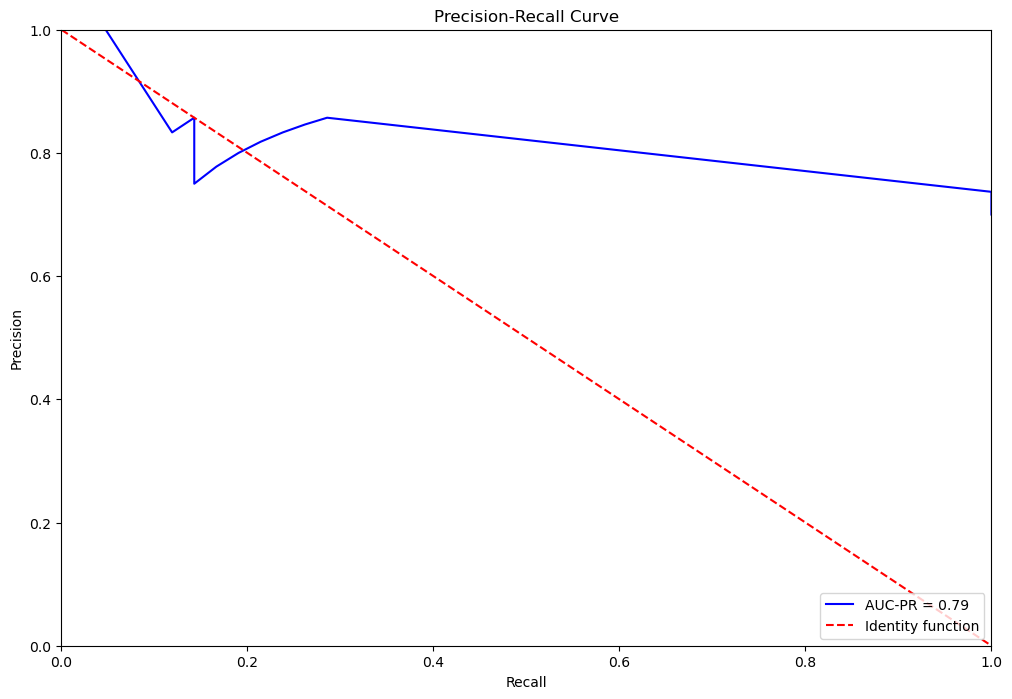

In [113]:
# plotting precision-recall curve
A_test1 = kernel_mat(X_test, X_train, 100)
y_log = kernelised_predict_log(A_test1, d1['beta'], d1['intercept'])
auc, precision, recall, th = precision_recall_curve(y_test_binary, y_log) 

plt.figure(figsize=(12,8))
plt.title(f'Precision-Recall Curve')
plt.plot(recall, precision, 'b', label=f'AUC-PR = {auc:0.2f}')
plt.plot([0, 1], [1,0], 'r--', label='Identity function')
plt.legend(loc='lower right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

In [114]:
# running the model
d2 = kernelised_model(X_train, y_train_binary, X_test, y_test_binary, alpha=0.3, num_iterations=500, learning_rate=0.1, print_loss=True)
print("alpha = 0.3")

Mean loss after iteration 0: 0.693147
Mean loss after iteration 100: 0.528921
Mean loss after iteration 200: 0.497216
Mean loss after iteration 300: 0.480677
Mean loss after iteration 400: 0.469650
Training accuracy: 80.6896551724138 %
Test accuracy: 83.33333333333334 %
alpha = 0.3


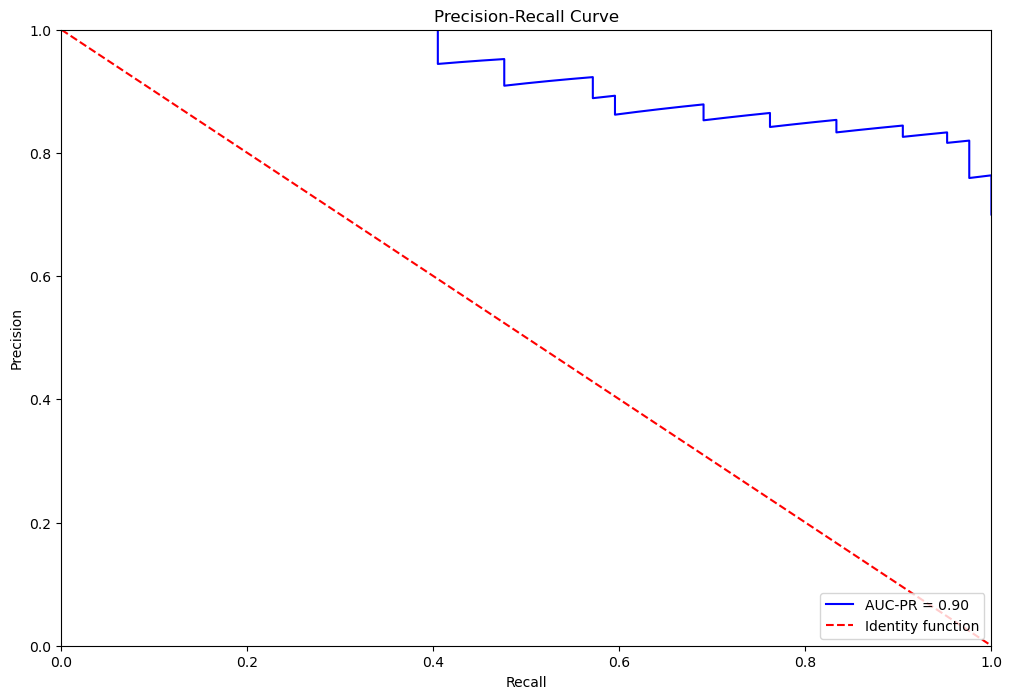

In [115]:
# plotting precision-recall curve
A_test2 = kernel_mat(X_test, X_train, 0.3)
y_log = kernelised_predict_log(A_test2, d2['beta'], d2['intercept'])
auc, precision, recall, th = precision_recall_curve(y_test_binary, y_log) 

plt.figure(figsize=(12,8))
plt.title(f'Precision-Recall Curve')
plt.plot(recall, precision, 'b', label=f'AUC-PR = {auc:0.2f}')
plt.plot([0, 1], [1,0], 'r--', label='Identity function')
plt.legend(loc='lower right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

The precision-recall curves above imply that $\lambda = 0.3$ performs significantly better than $\lambda = 100$. We have an AUC-PR of 0.90 for $\lambda = 0.3$ and an AUC-PR of 0.79 for $\lambda = 100$, implying that the model with $\lambda = 0.3$ is far more effective at identifying positive instances and not predicting false positives.

The training and test accuracies also agree with this. For test set, the accuracy of the model with $\lambda = 100$ is 70.0% compared to 83.3% for the model with $\lambda = 0.3$.

Compared to the penalised logistic regression model in 2.1.1., the test accuracies are much higher, with only 56.7% for the model in 2.1.1. 

The logistic regression model does however have an AUC-PR of 0.86 which is second best overall, just behind the model with $\lambda = 0.3$.